# Redo the energy budget with the PE terms done right

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import matplotlib.colors as mcolors
%matplotlib notebook
import xarray as xr
import xmitgcm as xgcm
import matplotlib.mlab as mlab
import jmkfigure
import scipy.io as sio
import dask.array as da
plt.style.use('ggplot')

/Users/jklymak/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:197: UserWarning: In /Users/jklymak/.matplotlib/stylelib/ggplotjmk.mplstyle: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(message)
/Users/jklymak/anaconda3/lib/python3.6/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
pre = 'CW3dfull01U10'
dss=[0,0,0]
v0 = np.zeros(3);u0 = np.zeros(3)
iters = [36000,36090,36180]
submean = True

In [3]:
N0=1e-3
g=9.8
alpha = 2e-4
dz=10.
T0 = 28-np.cumsum(N0**2/g/alpha*dz*np.ones(400))
U0 = 0.1
for i in range(3):
    n=i
    nm='%s/ds%010d.nc'%(pre,iters[i])
    print(nm)
    dss[i] = xr.open_dataset(nm, chunks={'Z':30,'Zl':30})
    ny = dss[i].sizes['YC']
    nx = dss[i].sizes['XC']
    
    dss[i]['T0']=(('Z'),T0)
    
    if submean:
        v0[i] = (dss[i]['V'].isel(Z=slice(50,200)).mean()).values
        u0[i] = (dss[i]['U'].isel(Z=slice(50,200)).mean()).values-U0
    else:
        v0[i]=0.
        u0[i]=0.
    #    indx = np.where(np.abs(dss[n]['X']-np.mean(dss[n]['X']))<34e3)[0]
    
    #    indx = np.where(np.abs(dss[n]['X']-np.mean(dss[n]['X']))<34e3)[0]
    dss[n]['V']=dss[n]['V']-v0[i]
    dss[n]['U']=dss[n]['U']-u0[i]
ds = dss[1]

CW3dfull01U10/ds0000036000.nc
CW3dfull01U10/ds0000036090.nc
CW3dfull01U10/ds0000036180.nc


In [4]:
print(ds.Zl)

<xarray.DataArray 'Zl' (Zl: 400)>
array([    0.,   -10.,   -20., ..., -3970., -3980., -3990.])
Coordinates:
  * Zl       (Zl) float64 0.0 -10.0 -20.0 -30.0 -40.0 -50.0 -60.0 -70.0 ...
Attributes:
    standard_name:      depth_at_upper_w_location
    long_name:          vertical coordinate of upper cell interface
    units:              m
    positive:           down
    axis:               Z
    c_grid_axis_shift:  -0.5


In [5]:
energy=[[],[],[]]
for n in range(3):
    energy[n] = dict()
    energy[n]['Z']=dss[n]['Z'].values
    energy[n]['time']=dss[n]['time'].values
    energy[n]['drF']=dss[n]['drF'].values
print()
energy[1]['Area']=ds['rA'].sum(dim=('XC','YC')).values
area = energy[1]['Area']
print(energy[1]['Area'])


48496639999.99998


In [135]:
print('Starting d(WP)/dz')
P = ds['PH'] # m^2/s^2
# This doesn't make any difference.  Why? Because mean w = 0, Dummy.  - (ds['T0'] - energy[1]['Tznew']).cumsum(axis=0)*2.e-4 * g * 10.
PL = (P[:,1:,:,:].data*ds['hFacC'][1:,:,:].data + P[:,:-1,:,:].data*ds['hFacC'][:-1,:,:].data)
PL = PL / (ds['hFacC'][1:,:,:].data + ds['hFacC'][:-1,:,:].data )
print(PL)
w = (ds['W'] +
     ds['W'].roll(XC=1).data +
     ds['W'].roll(XC=-1).data +
     ds['W'].roll(YC=1).data +
     ds['W'].roll(YC=-1).data)/5.
     
print(ds['W'].isel(Zl=slice(1, None)))
WP = np.zeros(len(energy[1]['Z'])+1)
WP[1:-1]=(((w.isel(Zl=slice(1, None)) * PL * ds['rA'])).sum(dim=('YC', 'XC')).values)[0]  # m^2 m^3/s^3
dWPz = np.diff(WP)/ds['drF']  # m^2 m^2/s^3
energy[1]['dWPdz'] = -dWPz


Starting d(WP)/dz
dask.array<truediv, shape=(1, 399, 128, 416), dtype=float64, chunksize=(1, 29, 128, 416)>
<xarray.DataArray 'W' (time: 1, Zl: 399, YC: 128, XC: 416)>
dask.array<getitem, shape=(1, 399, 128, 416), dtype=float64, chunksize=(1, 29, 128, 416)>
Coordinates:
    iter     (time) int64 36090
  * time     (time) timedelta64[ns] 8 days 08:30:00
  * XC       (XC) float64 492.3 1.477e+03 2.462e+03 3.446e+03 4.431e+03 ...
  * YC       (YC) float64 462.5 1.388e+03 2.312e+03 3.238e+03 4.162e+03 ...
  * Zl       (Zl) float64 -10.0 -20.0 -30.0 -40.0 -50.0 -60.0 -70.0 -80.0 ...
    rA       (YC, XC) float64 9.108e+05 9.108e+05 9.108e+05 9.108e+05 ...
    Depth    (YC, XC) float64 3.26e+03 3.27e+03 3.31e+03 3.37e+03 3.46e+03 ...
Attributes:
    standard_name:  sea_water_z_velocity
    long_name:      Vertical Component of Velocity
    units:          m s-1


/Users/jklymak/anaconda3/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


<IPython.core.display.Javascript object>


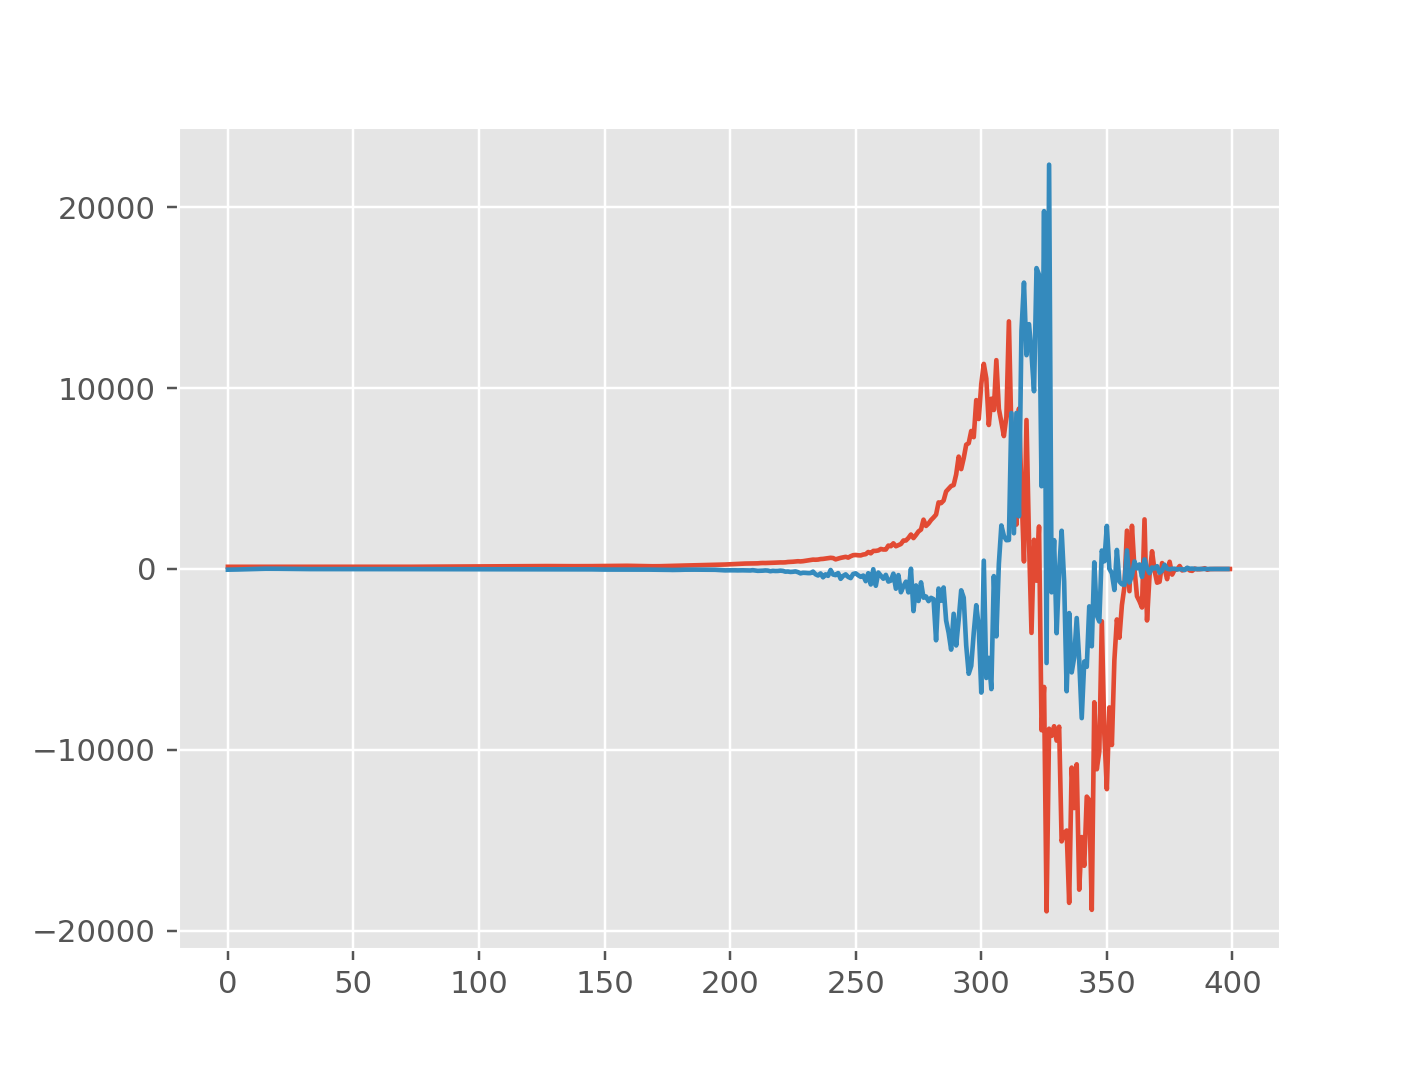

In [136]:
fig,ax = plt.subplots()
ax.plot(np.diff(WP))
ax.plot(np.diff(wE[0]))

In [8]:
print('Starting Body Force')
## Get the body force.... 
f0=1e-4
# clean up...
## sizes wrong here....
v = ds['V']

if 0:
    ds['VC'] = xr.DataArray(0.5*(ds['V'].data+
                             ds['V'].roll(YG=1).data),
                        dims=('time','Z','YC','XC'),
                        coords={'YC':ds['YC']})
xx=(ds['V']*ds['hFacS']*f0*U0*ds['rA'].data).sum(dim=('XC','YG'))
energy[1]['Bf'] = xx.data.compute()[0]

Starting Body Force


<IPython.core.display.Javascript object>


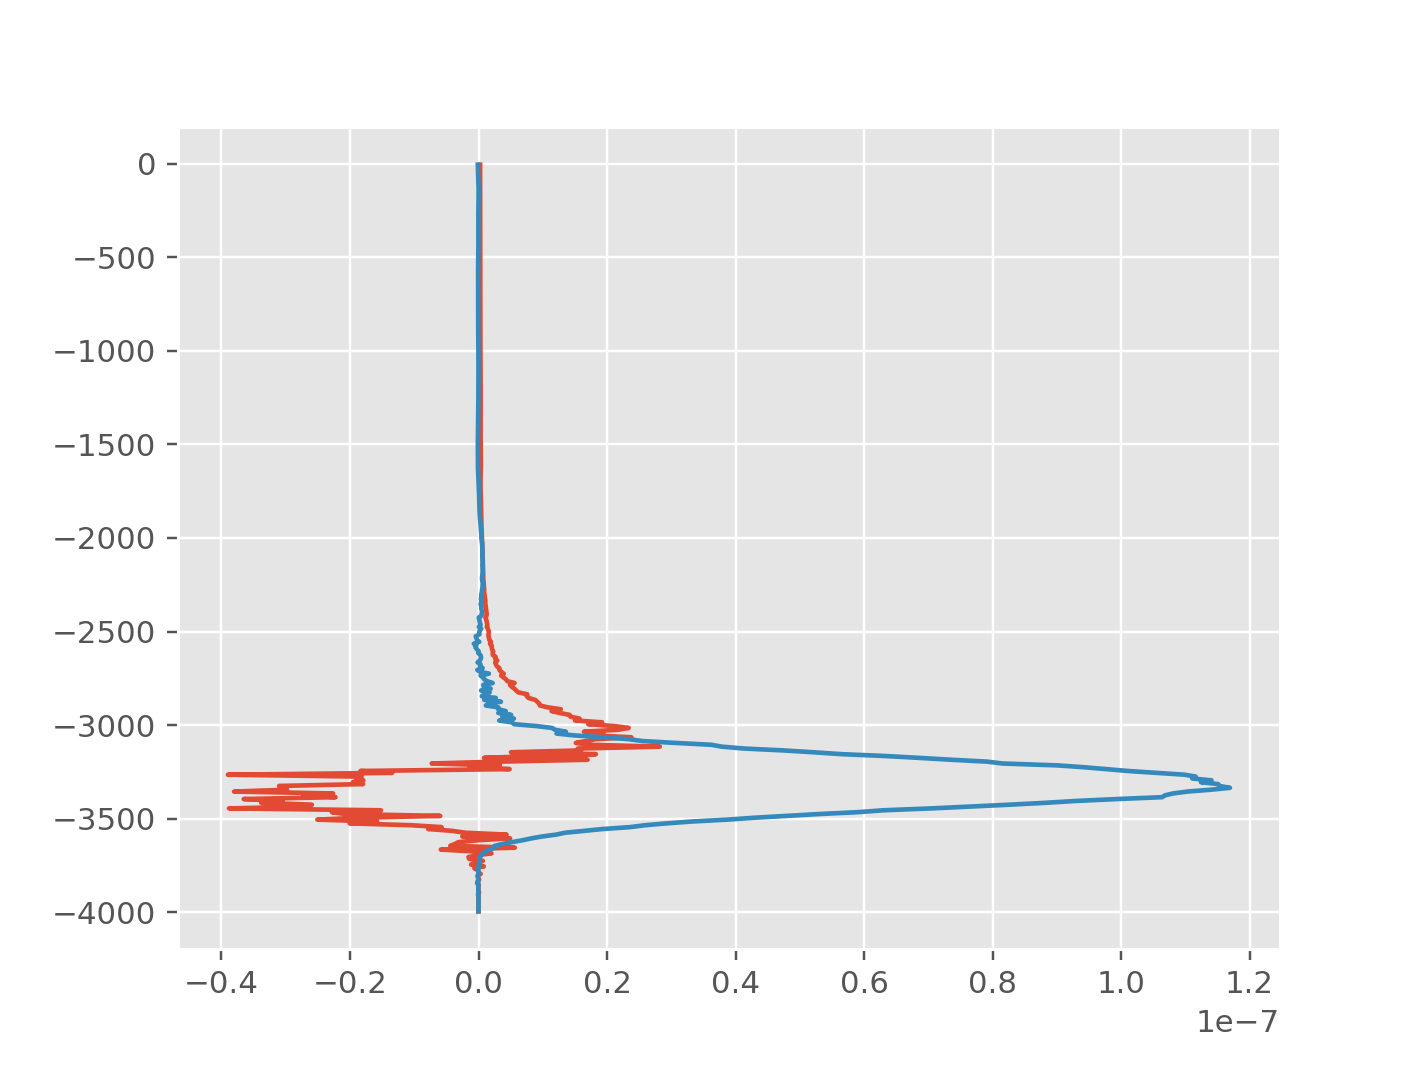

In [133]:
fig,ax = plt.subplots()
ax.plot(-energy[1]['dWPdz']/area,energy[1]['Z'],)
ax.plot(energy[1]['Bf']/area,energy[1]['Z'],)


In [112]:
for n in range(3):
    print('Starting KE')
    
    if 1:
        xx = (0.5*0.5*(dss[n]['U']**2 * dss[n]['hFacW'].data) *
          dss[n]['rA'].data).sum(dim=('YC','XG')).compute()
        xx += (0.5*0.5*(dss[n]['U'].roll(XG=1)**2 * dss[n]['hFacW'].roll(XG=1).data) *
           dss[n]['rA'].data).sum(dim=('YC','XG')).compute()
        xx += (0.5*0.5*(dss[n]['V']**2 * dss[n]['hFacS'].data) *
           dss[n]['rA'].data).sum(dim=('YG','XC')).compute()
        xx += (0.5*0.5*(dss[n]['V'].roll(YG=1)**2 * dss[n]['hFacS'].roll(YG=1).data) *
           dss[n]['rA'].data).sum(dim=('YG','XC')).compute()
    energy[n]['KE']=xx[0]
    energy[n]['PE'] = ((g*2e-4*(dss[n]['T']-dss[n]['T0']))**2/2./N0**2*
                       dss[n]['hFacC']*dss[n]['rA']).sum(dim=('XC','YC')).data.compute()[0]

Starting KE
Starting KE
Starting KE


In [123]:
for n in range(3):
    print('Starting KE')
    
    if 1:
        u = (dss[n]['U'] + dss[n]['U'].roll(XG=1).data)/2.
        xx = (0.5*(u**2 * dss[n]['hFacW'].data) *
          dss[n]['rA'].data).sum(dim=('YC','XG')).compute()
        v = (dss[n]['V'] + dss[n]['V'].roll(YG=1).data)/2.
        
        xx += (0.5*(v**2 * dss[n]['hFacS'].data) *
           dss[n]['rA'].data).sum(dim=('YG','XC')).compute()
    energy[n]['KE']=xx[0]
    energy[n]['PE'] = ((g*2e-4*(dss[n]['T']-dss[n]['T0']))**2/2./N0**2*
                       dss[n]['hFacC']*dss[n]['rA']).sum(dim=('XC','YC')).data.compute()[0]

Starting KE
Starting KE
Starting KE


In [67]:
# old way:

# get the mean temperature profile...
xx=0.


for n in range(3):
    energy[n]['areaZ'] = (dss[n]['hFacC']*dss[n]['rA']).sum(dim=('YC','XC')).compute()
    energy[n]['Tz'] = ((dss[n]['T']*dss[n]['hFacC']*dss[n]['rA']).sum(dim=('YC','XC')).isel(time=0).compute()/energy[n]['areaZ'])

# get a background N0 from Tz:
z = energy[1]['Z']
Tz = -np.sort(-energy[1]['Tz'].values)
rhoz = -Tz*2e-4
drhoz1 = np.diff(rhoz)/10. 
N00 = 0.*z
N00[1:-1] = 0.5 * (drhoz1[:-1] + drhoz1[1:])
N00[0] = drhoz1[0]
N00[-1] = drhoz1[-1]
N00 = N00 * g 
N00old = N00


/Users/jklymak/anaconda3/lib/python3.6/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive
/Users/jklymak/anaconda3/lib/python3.6/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive
/Users/jklymak/anaconda3/lib/python3.6/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


In [13]:
# new way


In [68]:
for n in range(3):
    t = dss[n]['T']
    t = t.where(t>20.)
    bins = np.linspace(t.min().values, t.max().values, 40000)
    t = dss[n]['T'].data
    tm = t.mean().compute()
    if n == 0:
        tm0 = tm
    else:
        print(tm0 - tm)
        t = t - tm + tm0
    # histogram the tempreatures...
    N, bins = da.histogram(t, bins)
    # get a curve of cumulative area as a function of temperature...
    cumareasT = np.cumsum(N.compute())*np.mean(dss[0]['rA'].values)
    Tbins = (bins[1:]+bins[:-1])/2.
    # get a curve of cumulative area as a function of depth
    cumareasZ = np.cumsum(energy[0]['areaZ'].values[::-1])
    Z = dss[n]['Z'][::-1] + 5.
    Z = Z[cumareasZ>1e-10]
    cumareasZ = cumareasZ[cumareasZ>1e-10]
    # get the depth of each temperature bin as a function of cumulative area.
    zTbin = np.interp(cumareasT, cumareasZ,Z)
    # now map back to grid z...  This is the minimum PE state 
    Tz = np.interp(energy[n]['Z'], zTbin, Tbins)
    # might as well make a proper array
    energy[n]['Tznew'] = energy[n]['Tz']*0.+Tz

/Users/jklymak/anaconda3/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


-4.24328590043e-07
-8.5828078511e-07


<IPython.core.display.Javascript object>


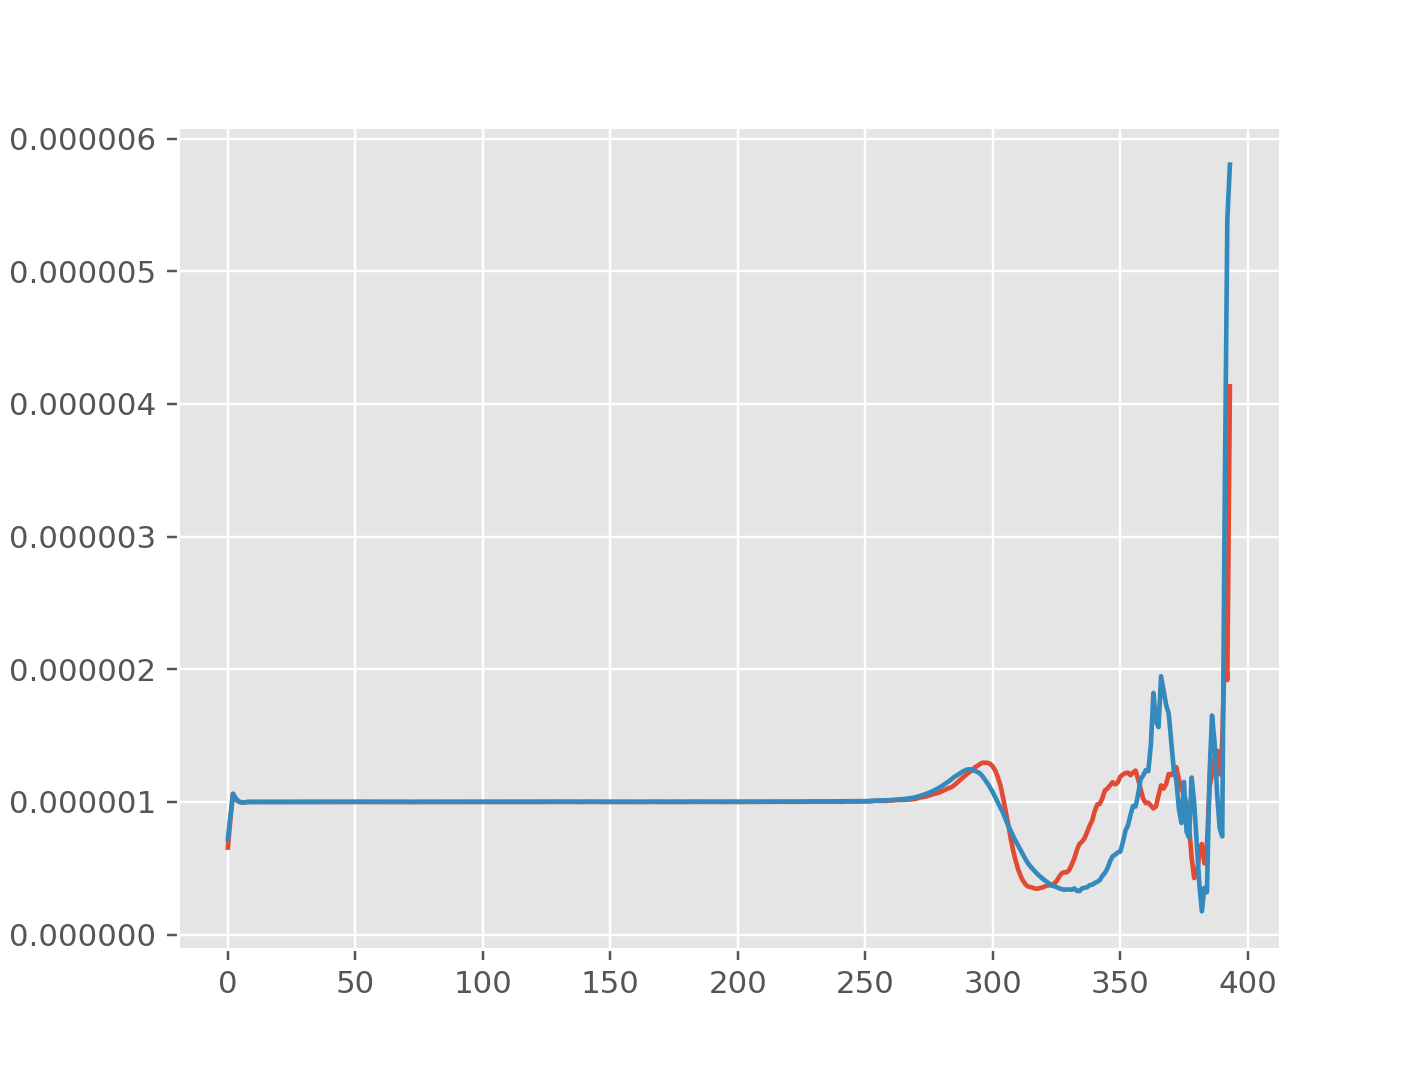

[  1.45150341e-06   2.17971529e-06   1.91893671e-06   4.13309446e-06
              nan              nan              nan              nan
              nan              nan]


In [15]:
Tz = -np.sort(-energy[1]['Tznew'])
rhoz = -Tz*2e-4
drhoz1 = np.diff(rhoz)/10. 
N00 = 0.*z
N00[1:-1] = 0.5 * (drhoz1[:-1] + drhoz1[1:])
N00[0] = drhoz1[0]
N00[-1] = drhoz1[-1]
N00 = N00 * g 
fig,ax = plt.subplots()
ax.plot(N00)
ax.plot(N00old)
print(N00[-10:])

In [16]:
for n in range(3):
    energy[n]['PEw'] = ((g*2.e-4*(dss[n]['T'] - energy[1]['Tznew']))**2 / 2. / N00[np.newaxis,:,np.newaxis,np.newaxis] * 
                       dss[n]['hFacC'] * dss[n]['rA']).sum(dim=('XC','YC')).data.compute()[0]
    
n = 0

<xarray.DataArray ()>
array(-223427753.0372733)
Coordinates:
    iter     int64 36000
    time     timedelta64[ns] 8 days 08:00:00
<xarray.DataArray ()>
array(-223427737.72308165)
Coordinates:
    iter     int64 36180
    time     timedelta64[ns] 8 days 09:00:00
<xarray.DataArray ()>
array(-3.1577840525494916e-10)


<IPython.core.display.Javascript object>


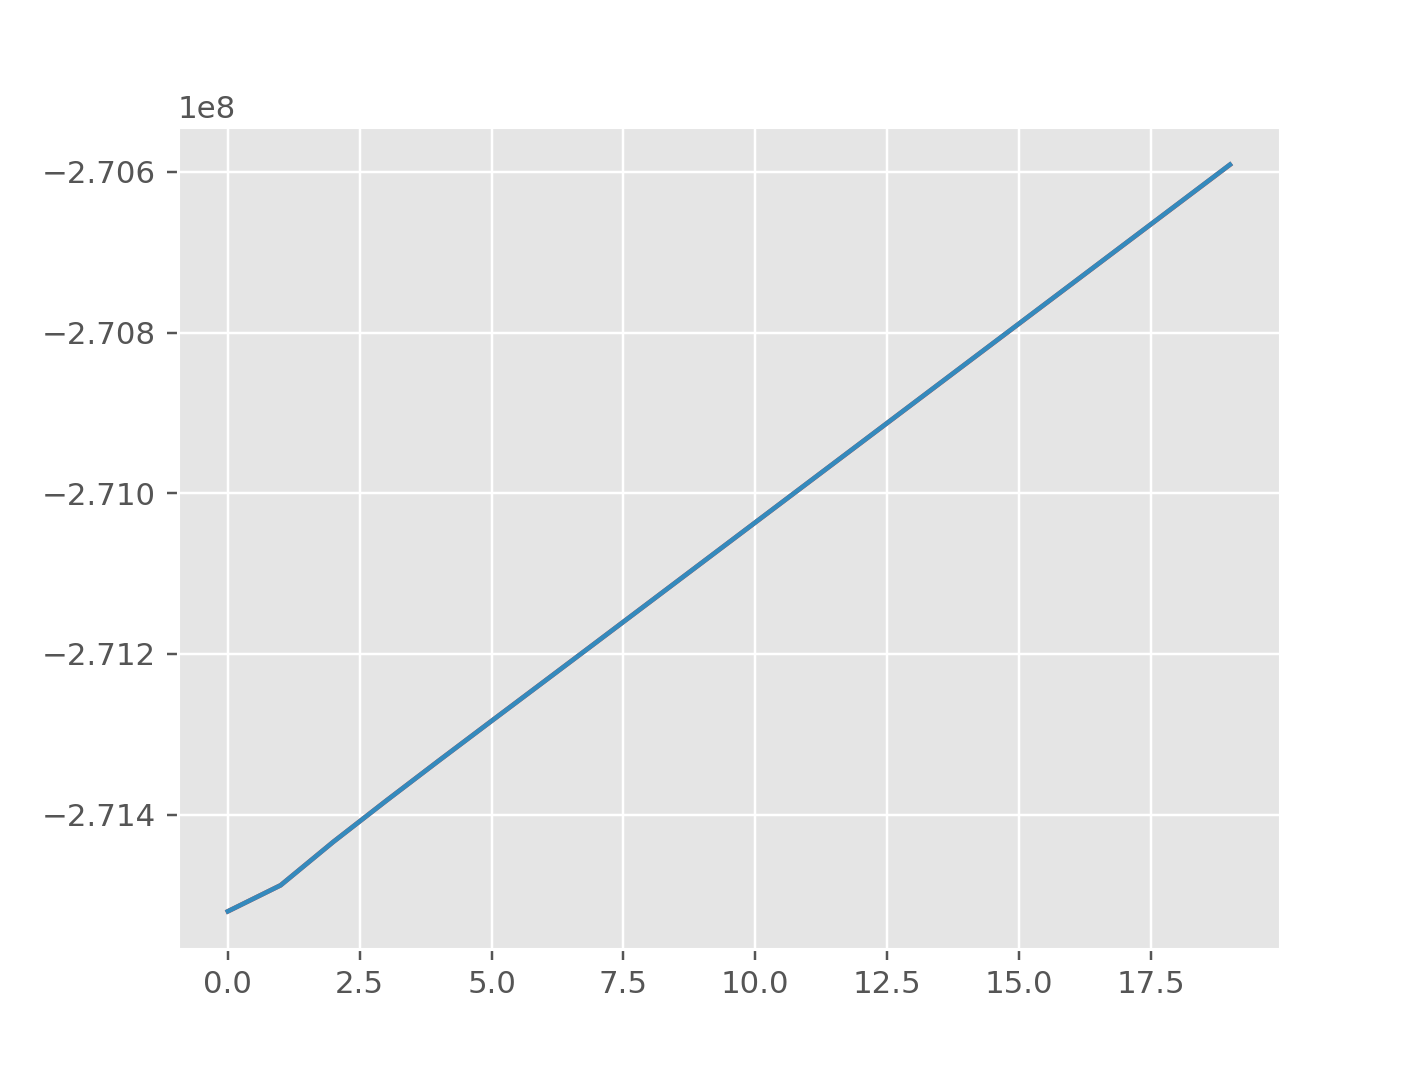

<IPython.core.display.Javascript object>


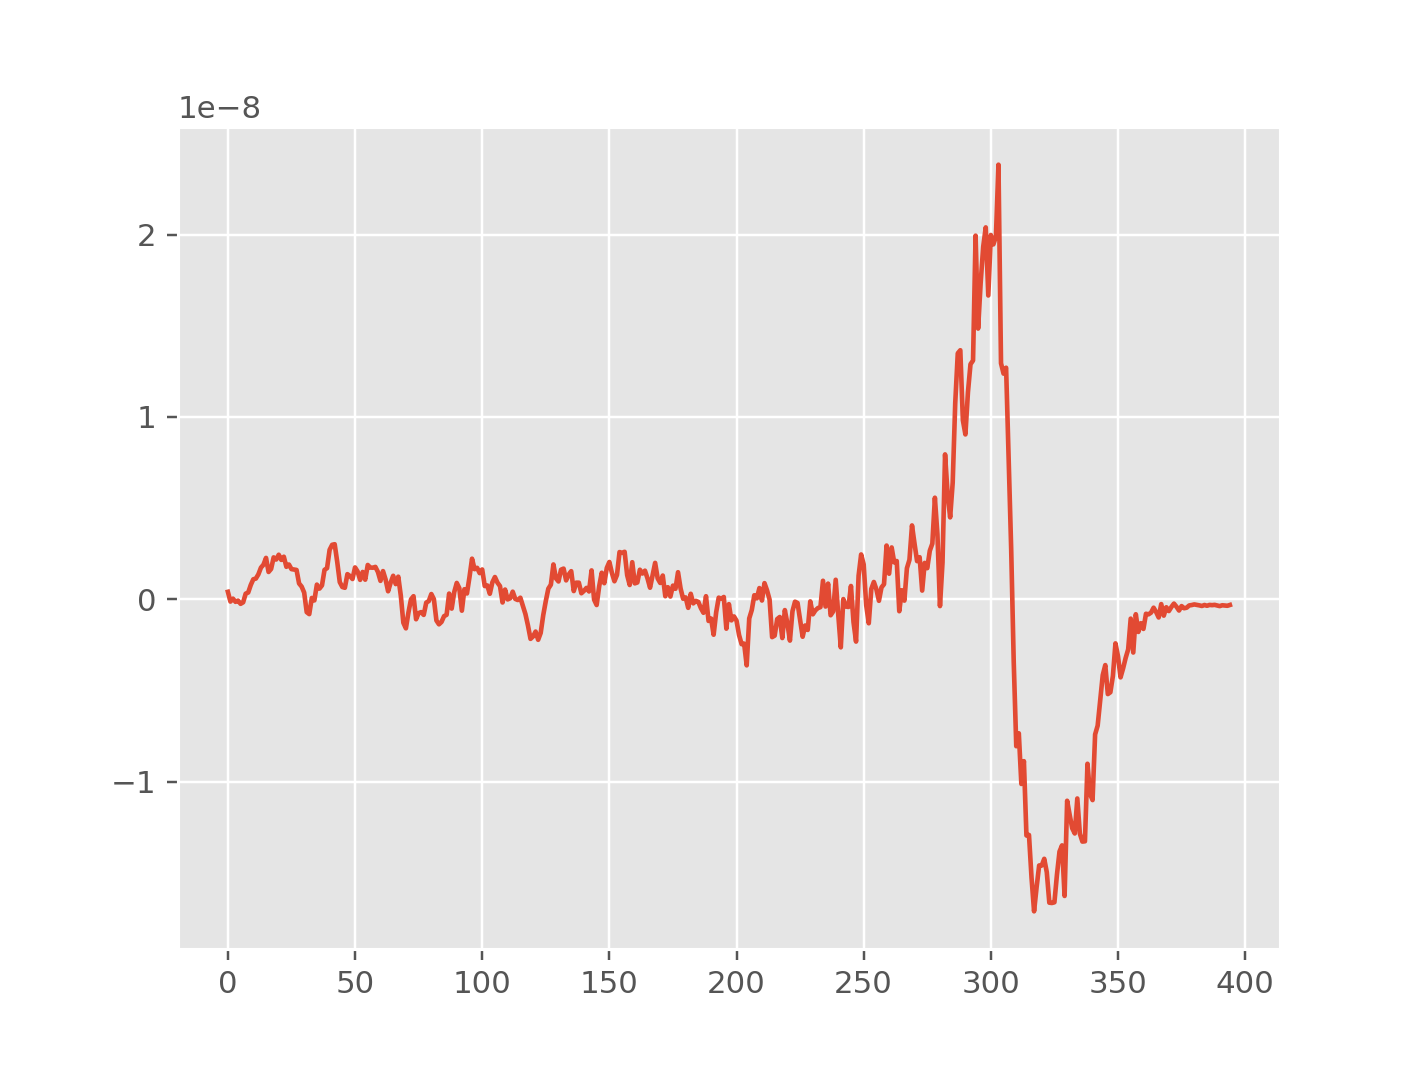

<IPython.core.display.Javascript object>


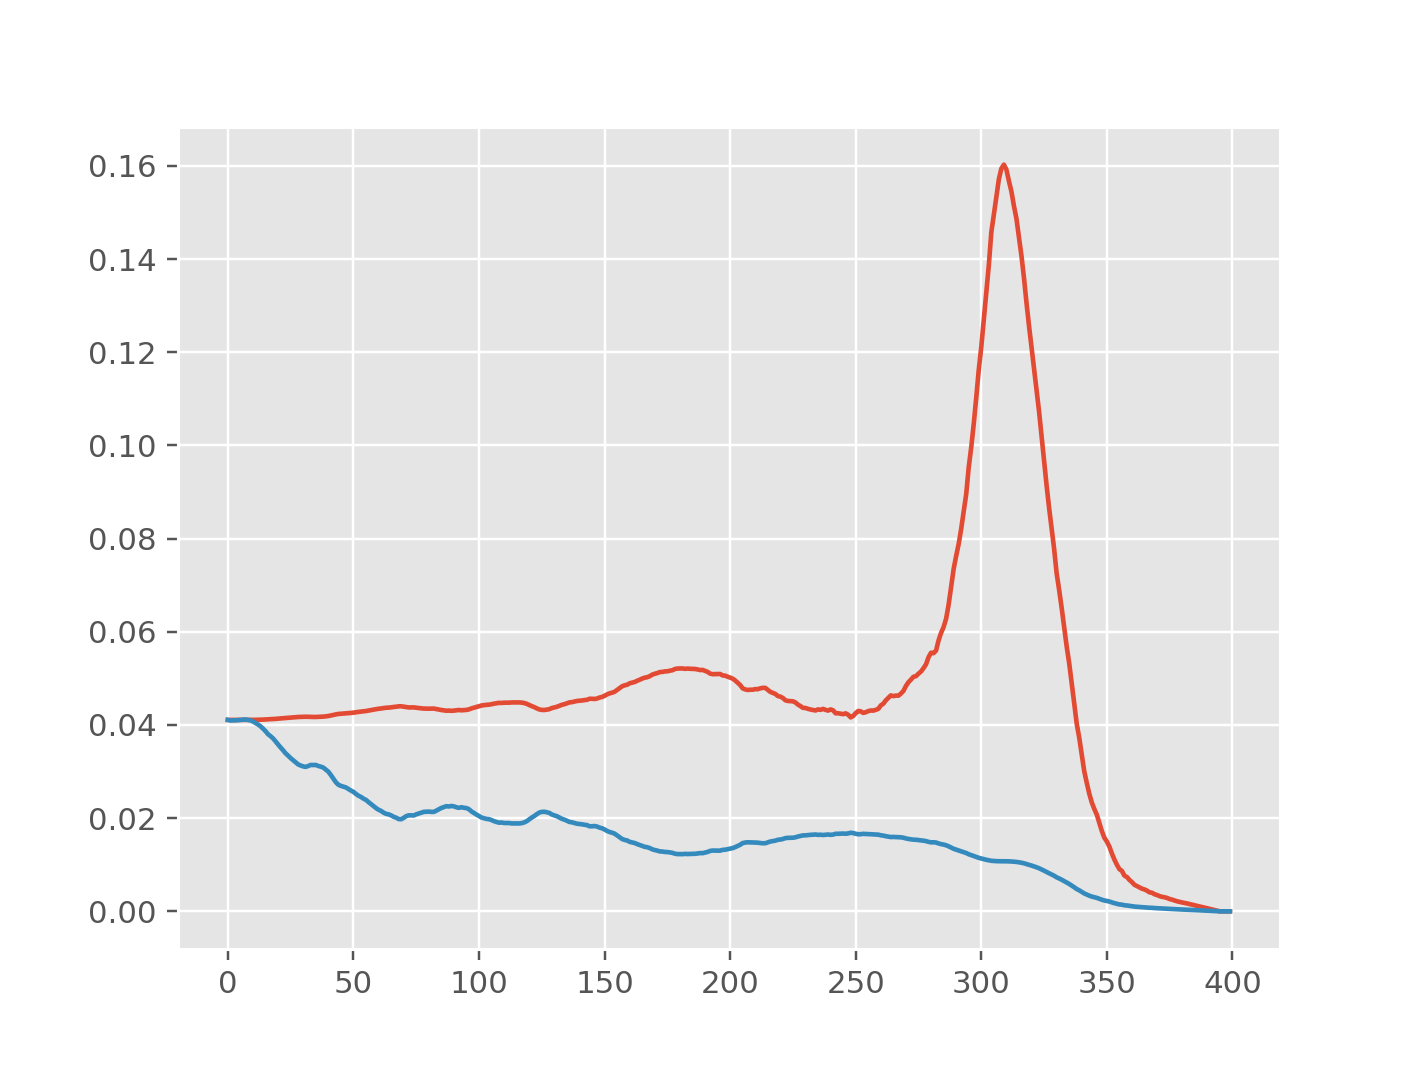

DIff
<xarray.DataArray ()>
array(11.411880470252974)
Coordinates:
    Z        float64 -5.0
    drF      float64 10.0
    PHrefC   float64 49.05
DIff 2
<xarray.DataArray ()>
array(11.411880642086183)
Coordinates:
    Z        float64 -5.0
    drF      float64 10.0
    PHrefC   float64 49.05


<IPython.core.display.Javascript object>


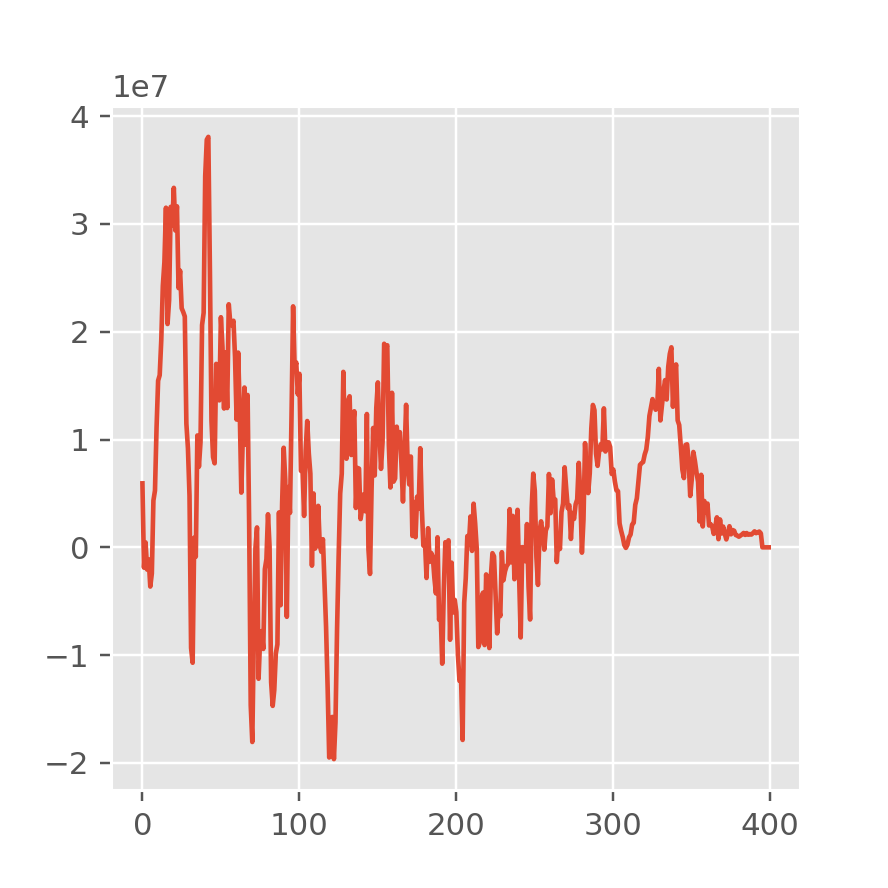

In [17]:
Tz = -np.sort(-energy[1]['Tznew'].values)
FullPE = 0.*dss[n]['T'].values[0]
rhoz = -Tz*2e-4
rho = -dss[n]['T'][0].values*2.e-4


#ax.plot(rhoz,dss[0]['Z'])
rho0 = -2e-4*(energy[0]['Tznew'])*energy[0]['areaZ']
rho2 = -2e-4*(energy[2]['Tznew'])*energy[0]['areaZ']
print(rho0.mean())
print(rho2.mean())
print((-rho2.mean() + rho0.mean())/area)
rho2 = rho2 +(- rho2.mean() + rho0.mean())
#rho0 = rho0 - rho0.mean() + rho2.mean()

fig,ax = plt.subplots()
ax.plot(rho0[:20])
ax.plot(rho2[:20])

fig,ax = plt.subplots()
ax.plot((rho2 - rho0)/area)


fig,ax = plt.subplots()
#ax.plot((rho2 - rho0)/area)

PE0 = (rho0 * g * dss[0]['Z'] * dss[0]['drF']).values
PE2 = (rho2 * g * dss[0]['Z'] * dss[0]['drF']).values
PE0[np.isnan(PE0)] = 0.
PE2[np.isnan(PE2)] = 0.
ax.plot(np.cumsum(((PE2 - PE0)/area)[::-1])[::-1])

print('DIff')
print((PE2.sum()-PE0.sum())/energy[0]['areaZ'][0]/3600.*1e6)

PE0 = (rho0 * g * (dss[0]['Z']+3081) * dss[0]['drF']).values
PE2 = (rho2 * g * (dss[2]['Z']+3081) * dss[0]['drF']).values
PE0[np.isnan(PE0)] = 0.
PE2[np.isnan(PE2)] = 0.

ax.plot(np.cumsum(((PE2 - PE0)/area)[::-1])[::-1])

print('DIff 2')
print((PE2.sum()-PE0.sum())/energy[0]['areaZ'][0]/3600.*1e6)

rhoz[np.isnan(rhoz)]=np.max(rhoz[np.isfinite(rhoz)])
z = -dss[1]['Z'].values
zf = np.arange(0,4000.,0.25)
rhozf = np.interp(zf,-dss[1]['Z'].values,rhoz,right=rhoz[-1],left=rhoz[0],)

fig,ax = plt.subplots(figsize=(4,4))
ax.plot(PE2-PE0)
#fig,ax = plt.subplots(figsize=(4,4))
#ax.pcolormesh(x,-z,rho[:,0,:]-rhoz[:,np.newaxis],vmin=-0.00001,vmax=0.00001,cmap='RdBu_r')
#print(rhozf[10:30])

In [18]:
# OK, thats one way to skin the cat.  Now, what about 

In [19]:
rho0 = -T0*2e-4
PE = (rho - rho0[:, np.newaxis, np.newaxis])**2*g**2/1e-6/2.
PE[rho==0]=0.

In [20]:
fig,ax = plt.subplots()
pcm=ax.pcolormesh(x,-z,zeta[:,0,:],vmin=-190,vmax=190., cmap='RdBu_r')
fig.colorbar(pcm)

fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
pcm=ax[0].pcolormesh(x,-z,FullPE[:,0,:],vmin=-0.02,vmax=0.02, cmap='RdBu_r')
fig.colorbar(pcm,ax=ax[0])

pcm=ax[1].pcolormesh(x,-z,PE[:,0,:],vmin=-0.02,vmax=0.02, cmap='RdBu_r')
fig.colorbar(pcm)
fig.tight_layout()


<IPython.core.display.Javascript object>

NameError: name 'x' is not defined

## conclusion: PE

So, these versions of PE are indeed different.  Now, a good question is if we can approximate the full PE using a few terms of the Taylor series.  That has the advantage of being a local calculation.

/Users/jklymak/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/jklymak/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide
/Users/jklymak/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Users/jklymak/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/jklymak/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in true_divide
/Users/jklymak/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


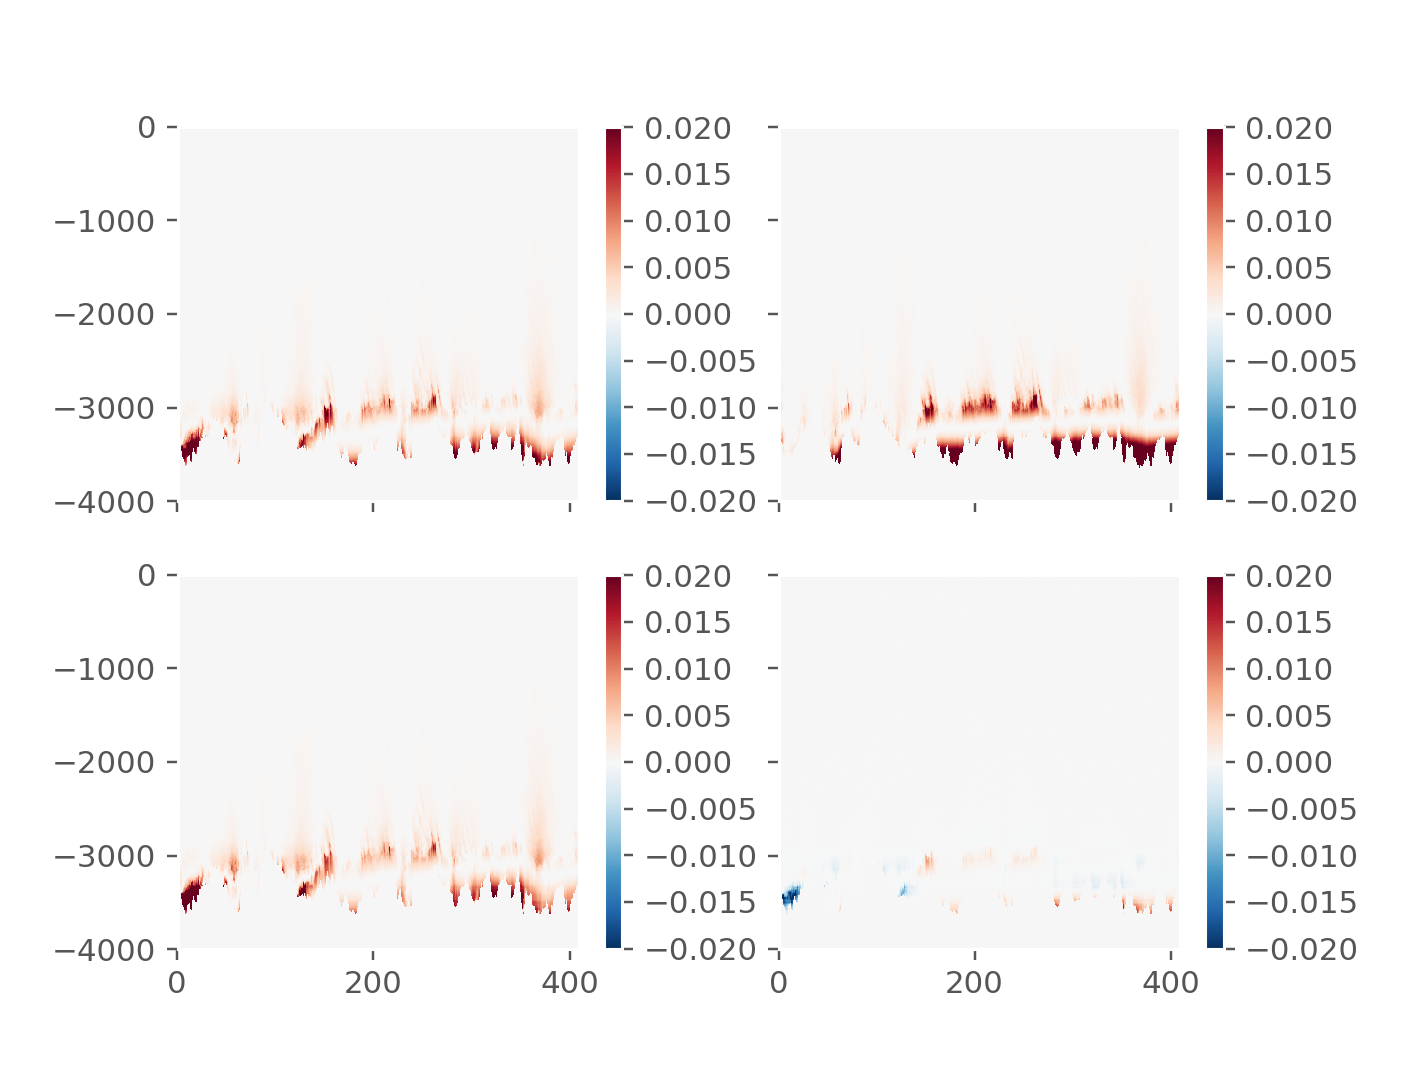

In [219]:
# local PE using rhoz

drhoz1 = np.diff(rhoz)/10.  # on midpoints
drhoz2 = 0.*z
drhoz2[1:-1] = np.diff(drhoz1)/10. # on interior main points
drhoz3 = np.diff(drhoz2)/10.# on midpoints

drhoz1 = np.interp(z,z[:-1]+5.,drhoz1)
drhoz4 = 0.*z
drhoz4[1:-1] = np.diff(drhoz3)/10. # on interior main points
drhoz3 = np.interp(z,z[:-1]+5.,drhoz3)



PEBR1 = 0*PE
PEBR2 = 0*PE
PEBR3 = 0*PE

PEBR1 = 0.5*g*(rho-rhoz[:,np.newaxis,np.newaxis])**2/drhoz1[:,np.newaxis,np.newaxis]

PEBR2 = PEBR1 - drhoz2[:,np.newaxis,np.newaxis] / 6. * (rho-rhoz[:,np.newaxis,np.newaxis])**3 / drhoz1[:,np.newaxis,np.newaxis]**3

PEBR3 = PEBR2 + drhoz3[:,np.newaxis,np.newaxis] / 24. * (rho-rhoz[:,np.newaxis,np.newaxis])**4 / drhoz1[:,np.newaxis,np.newaxis]**4

PEBR4 = PEBR3 - drhoz4[:,np.newaxis,np.newaxis] / 24./5. * (rho-rhoz[:,np.newaxis,np.newaxis])**5 / drhoz1[:,np.newaxis,np.newaxis]**5

PEBR1[rho==0] = 0.
PEBR2[rho==0] = 0.
PEBR3[rho==0] = 0.

fig,ax = plt.subplots(2,2,sharex=True,sharey=True)
ax = ax.ravel()
pcm=ax[0].pcolormesh(x,-z,FullPE[:,0,:],vmin=-0.02,vmax=0.02, cmap='RdBu_r')
fig.colorbar(pcm,ax=ax[0])

pcm=ax[1].pcolormesh(x,-z,PE[:,0,:],vmin=-0.02,vmax=0.02, cmap='RdBu_r')
fig.colorbar(pcm,ax=ax[1])

pcm=ax[2].pcolormesh(x,-z,PEBR1[:,0,:],vmin=-0.02,vmax=0.02, cmap='RdBu_r')
fig.colorbar(pcm,ax=ax[2])

pcm=ax[3].pcolormesh(x,-z,FullPE[:,0,:]-PEBR1[:,0,:],vmin=-0.02,vmax=0.02, cmap='RdBu_r')
fig.colorbar(pcm,ax=ax[3])




<IPython.core.display.Javascript object>


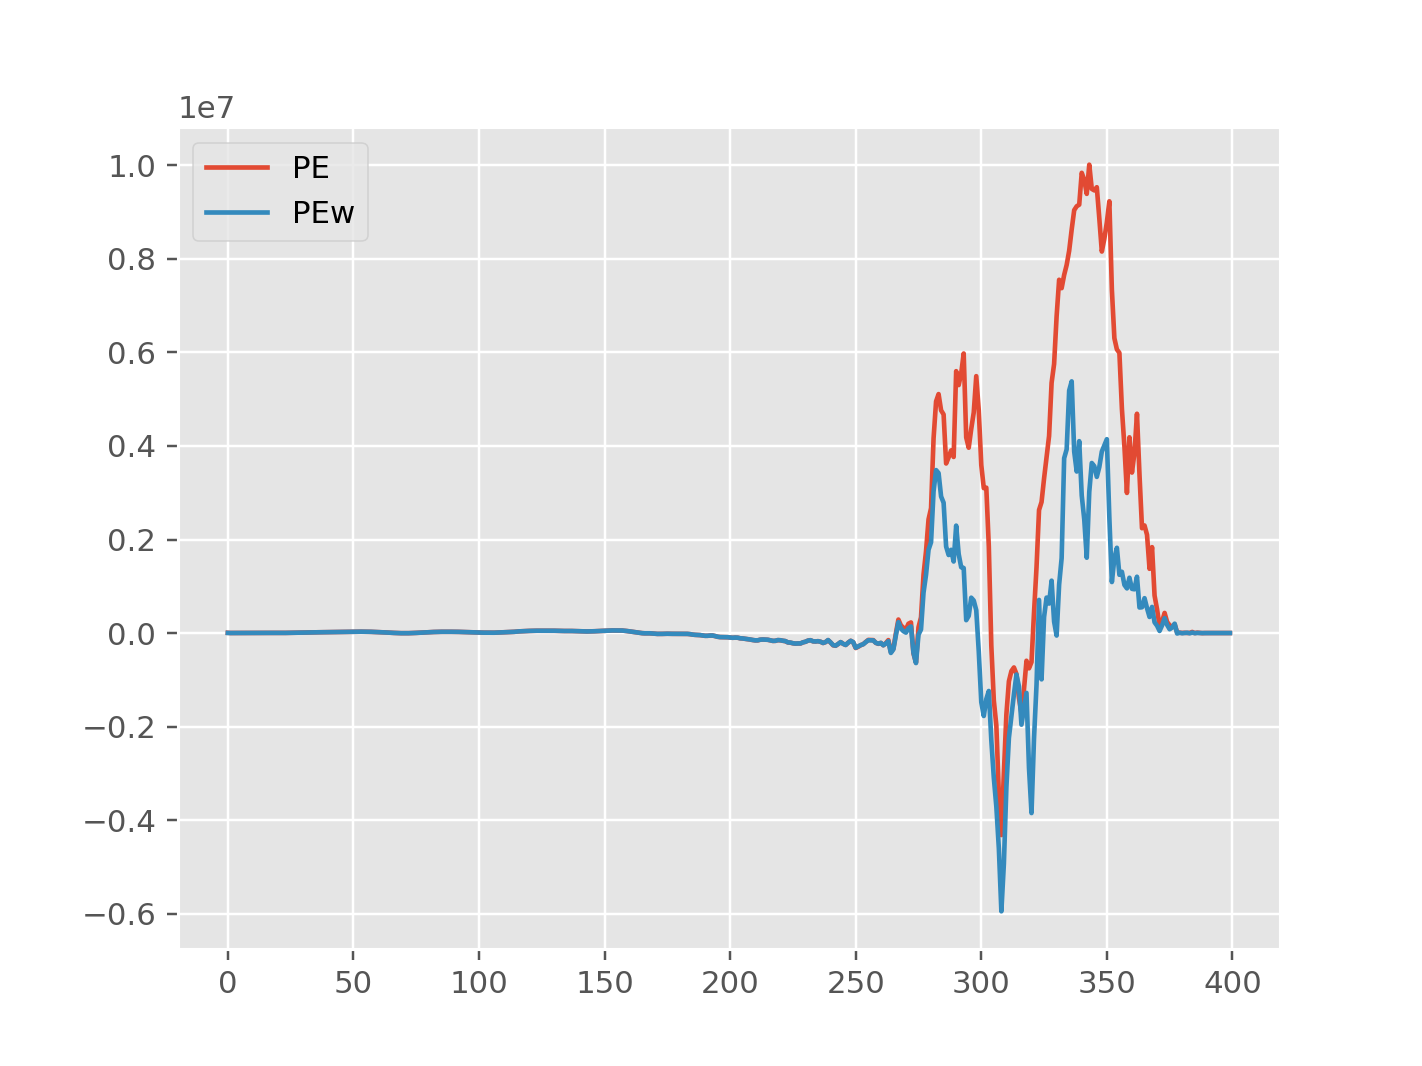

In [231]:
fig,ax = plt.subplots()

ax.plot((energy[2]['PE']-energy[0]['PE'])/3600.*area/1e6,label='PE')
ax.plot((energy[2]['PEw']-energy[0]['PEw'])/3600.*area/1e6,label='PEw')
ax.legend()


<IPython.core.display.Javascript object>


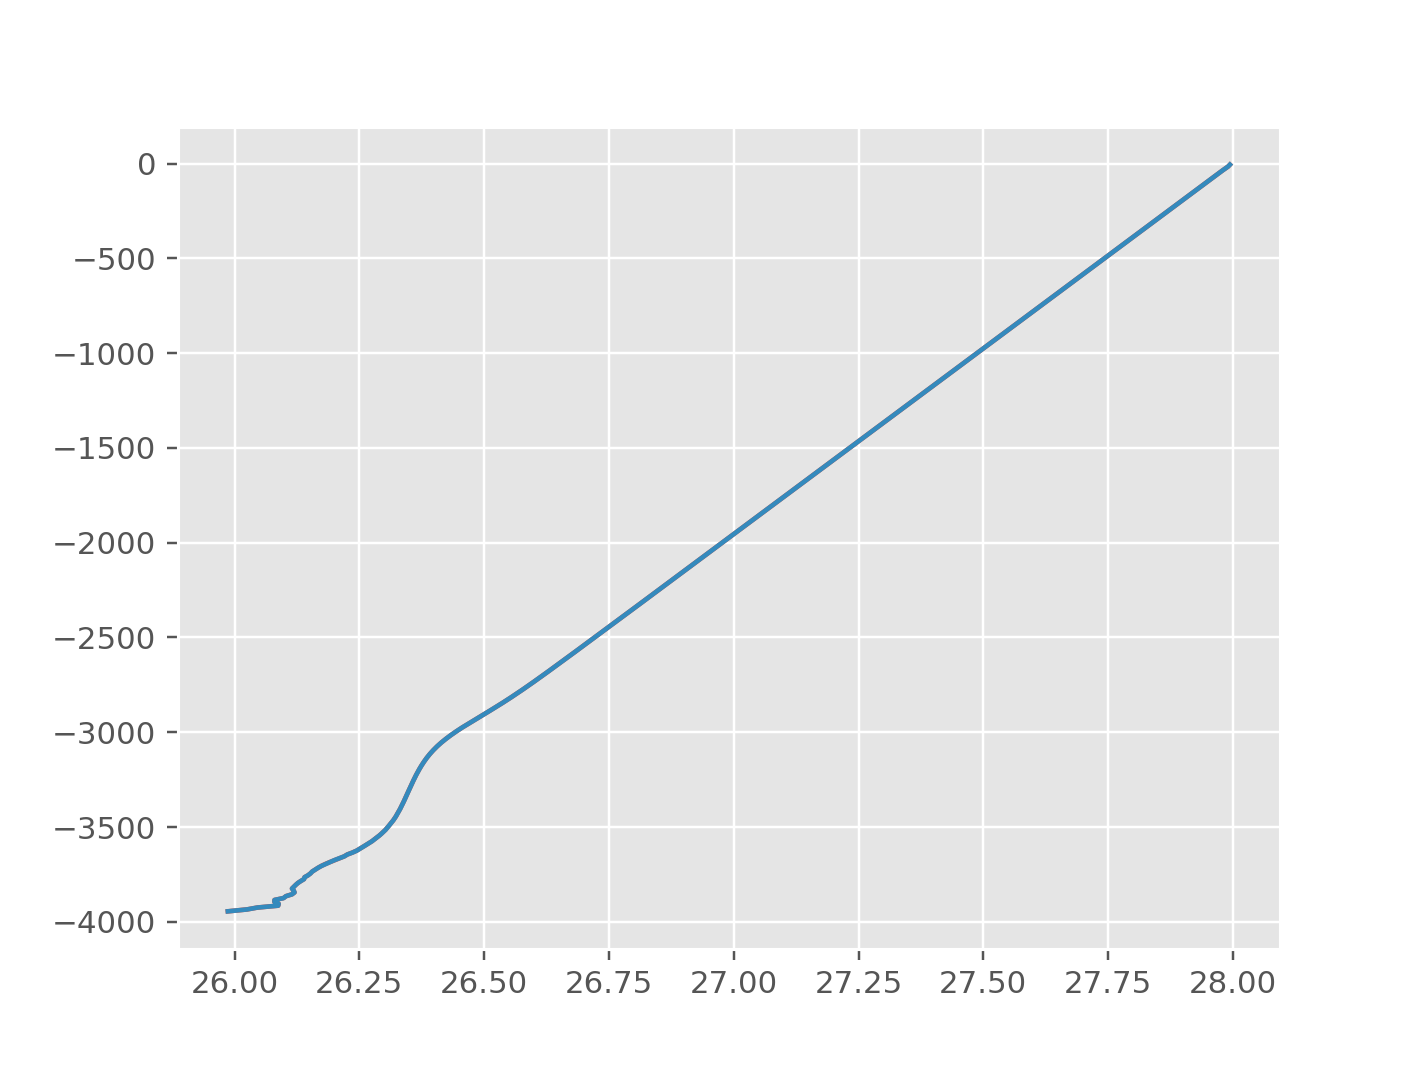

In [74]:
fig,ax = plt.subplots()
ax.plot(dss[0]['Tz'][0],dss[0]['Z'])
ax.plot(dss[1]['Tz'][0],dss[0]['Z'])



In [50]:
for n in range(3):
    print('Starting PE0')
    energy[n]['PE0'] = (g*(2e-4*(dss[n]['T']-dss[n]['T0'])) * (dss[n]['Z'])* 
                       dss[n]['hFacC']*dss[n]['rA']).sum(dim=('XC','YC')).data.compute()[0]
    

Starting PE0


/Users/jklymak/anaconda3/lib/python3.6/site-packages/dask/array/rechunk.py:347: RuntimeWarning: invalid value encountered in double_scalars
  key=lambda k: np.log(graph_size_effect[k]) / np.log(block_size_effect[k]),


Starting PE0


/Users/jklymak/anaconda3/lib/python3.6/site-packages/dask/array/rechunk.py:347: RuntimeWarning: invalid value encountered in double_scalars
  key=lambda k: np.log(graph_size_effect[k]) / np.log(block_size_effect[k]),


Starting PE0


/Users/jklymak/anaconda3/lib/python3.6/site-packages/dask/array/rechunk.py:347: RuntimeWarning: invalid value encountered in double_scalars
  key=lambda k: np.log(graph_size_effect[k]) / np.log(block_size_effect[k]),


In [119]:
# get d/dz wE:
n = 1
if 0:
    w = dss[n]['W'].data
else:
    w = (dss[n]['W'].data +
         dss[n]['W'].roll(XC=1).data +
         dss[n]['W'].roll(XC=-1).data +
         dss[n]['W'].roll(YC=-1).data +
         dss[n]['W'].roll(YC=1).data)/5.
smoothU = True
if smoothU:
    u = (dss[n]['U'] +
         dss[n]['U'].roll(XG=1).data +
         dss[n]['U'].roll(XG=-1).data +
         dss[n]['U'].roll(YC=1).data +
         dss[n]['U'].roll(YC=-1).data)/5. # +dss[n]['U'].roll(XG=-1).data + dss[n]['U'].roll(Z=-1).data)/4. 
else:
    u = dss[n]['U']
#xx = (0.5*(((u-0.1)**2 + 0.*2.*(u-0.1)*0.1)* dss[n]['rA'].data * dss[n]['hFacC'].data * 
#           dss[n]['W'].data)).sum(dim=('XG','YC')).compute()
xx = (0.5*((u**2) * dss[n]['rA'].data * dss[n]['hFacC'].data * 
           w)).sum(dim=('XG','YC')).compute()
uu = xx.copy()
#xx += (0.5*0.5*(dss[n]['U'].roll(XG=1)**2 ) *
#       dss[n]['rA'].data * dss[n]['W'].data).sum(dim=('XG','YC')).compute()
#v = 0.2*(dss[n]['V']+dss[n]['V'].roll(YG=1)+dss[n]['V'].roll(YG=-1)+dss[n]['V'].roll(XC=1)++dss[n]['V'].roll(XC=-1))
if smoothU:
    v = (dss[n]['V'] + 
         dss[n]['V'].roll(YG=1).data +
         dss[n]['V'].roll(YG=-1).data +
         dss[n]['V'].roll(XC=-1).data +
         dss[n]['V'].roll(XC=1).data)/5.
else:
    v = dss[n]['V']
xx = xx + (0.5*(v**2 ) * dss[n]['hFacC'].data *
       dss[n]['rA'].data * w).sum(dim=('XC','YG')).compute()
vv = xx.copy() - uu.copy()


#xx = xx + (0.5*(w**3 ) * dss[n]['hFacC'].data *
#       dss[n]['rA'].data).sum(dim=('XC','YC')).data


#xx = xx*2.
#xx += (0.5*0.5*(dss[n]['V'].roll(YG=1)**2 ) *
#       dss[n]['rA'].data* dss[n]['W'].data).sum(dim=('XC','YG')).compute()
T = dss[n]['T'].values[0]
nz,ny,nx = np.shape(T)
for k in range(nz):
    T[k][T[k]==0]=(energy[n]['Tz'].values)[k]
dss[n]['Tf'] = dss[n]['T']*0. + T   


if 1:
    t = (dss[n]['Tf'] + dss[n]['Tf'].roll(YC=1).data + dss[n]['Tf'].roll(YC=-1).data 
          + dss[n]['Tf'].roll(XC=1).data + dss[n]['Tf'].roll(YC=-1).data)/5.
else:
    t = dss[n]['T']
xx += (((g * 2e-4 * (t - energy[1]['Tznew']) * dss[n]['hFacC'])**2 / 2. / N00[np.newaxis,:,np.newaxis,np.newaxis]) * 
          dss[n]['rA']* w).sum(dim=('XC','YC')).compute()
#xx += ((g*2e-4*(dss[n]['T']-dss[n]['Tz']))*dss[n]['hFacC']*dss[n]['rA']*(dss[n]['Z']) * dss[n]['W'].data).sum(dim=('XC','YC')).compute()


wE = xx

# xx is KE on Z, but W is on Z1

In [120]:
energy[1]['dwEdz'] = 0*energy[1]['Z']
print(energy[0]['areaZ'])
energy[1]['dwEdz'][:-1] = -np.diff(xx[0])/10. #+ np.diff(energy[0]['areaZ'])/10.*xx[0,:-1]/energy[0]['areaZ'][:-1]

<xarray.DataArray (Z: 400)>
array([  4.849664e+10,   4.849664e+10,   4.849664e+10, ...,   0.000000e+00,
         0.000000e+00,   0.000000e+00])
Coordinates:
  * Z        (Z) float64 -5.0 -15.0 -25.0 -35.0 -45.0 -55.0 -65.0 -75.0 ...
    drF      (Z) float64 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 ...
    PHrefC   (Z) float64 49.05 147.2 245.2 343.4 441.5 539.6 637.6 735.8 ...


<IPython.core.display.Javascript object>


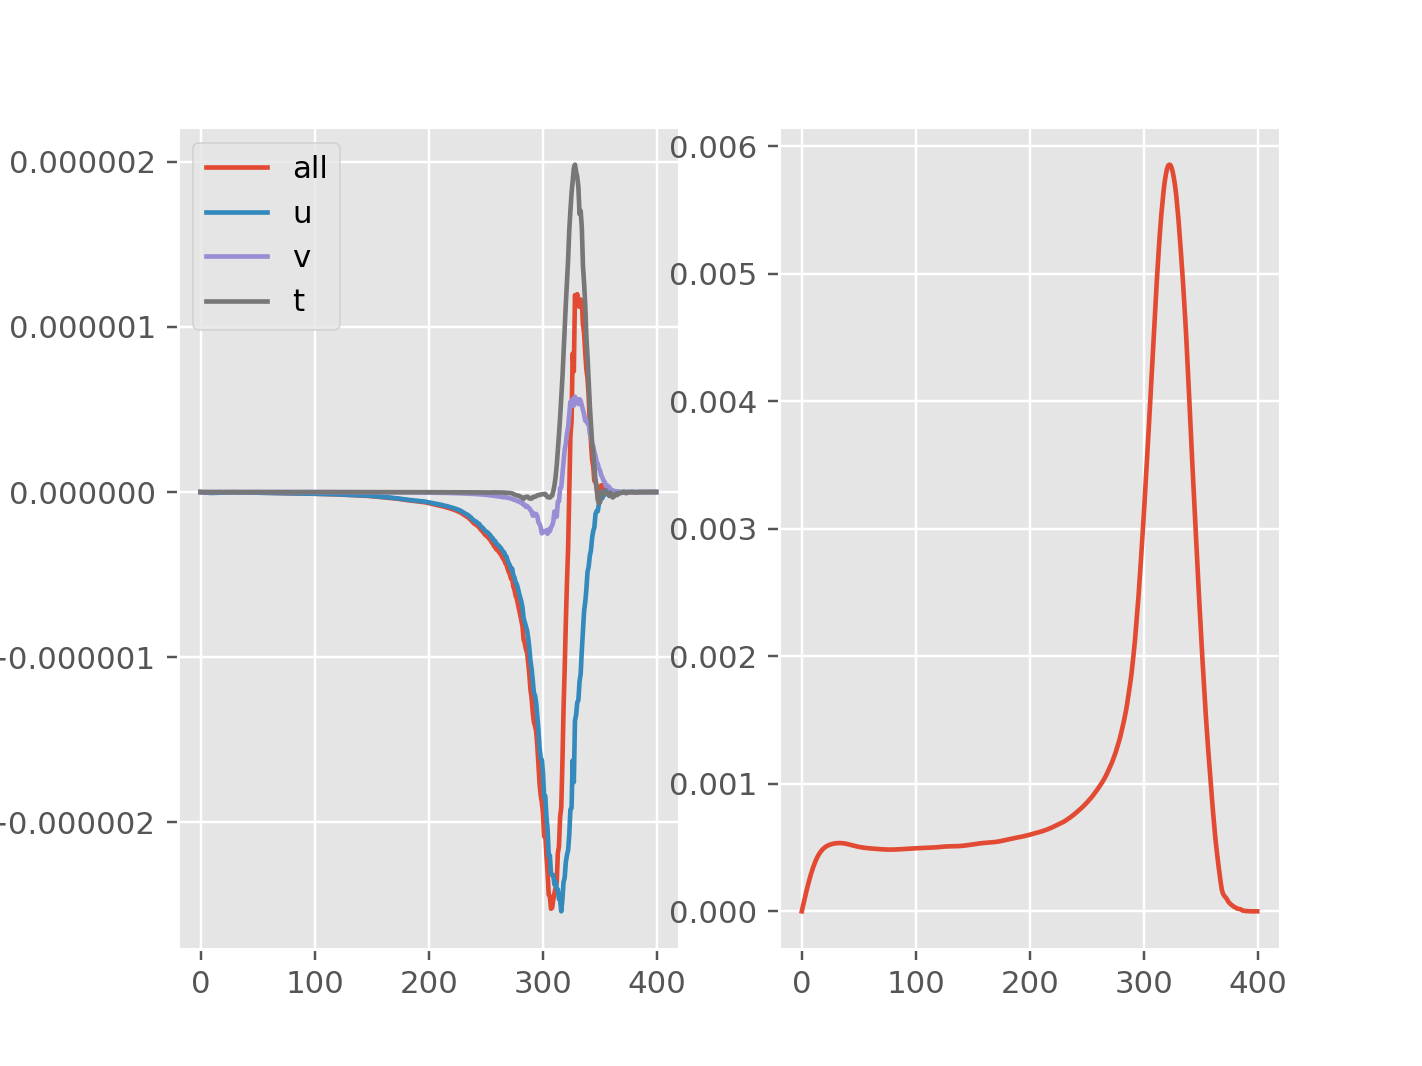

In [121]:
n = 0
tt = (((g * 2e-4 * (t - energy[1]['Tznew']) * dss[n]['hFacC'])**2 / 2. / N00[np.newaxis,:,np.newaxis,np.newaxis]) * 
          dss[n]['rA']* dss[n]['W'].data).sum(dim=('XC','YC')).compute()

fig, ax = plt.subplots(1,2)
ax[0].plot(np.convolve((xx[0])/area,np.ones(1)/1,mode='same'), label='all')
ax[0].plot(np.convolve((uu[0])/area,np.ones(1)/1,mode='same'), label='u')
ax[0].plot(np.convolve((vv[0])/area,np.ones(1)/1,mode='same'), label='v')
ax[0].plot(np.convolve((tt[0])/area,np.ones(1)/1,mode='same'), label='t')
ax[0].legend()
ax[1].plot(np.sqrt((dss[0]['W'][0]**2).mean(dim=('XC','YC'))))
#ax.plot(xx[0])

<IPython.core.display.Javascript object>


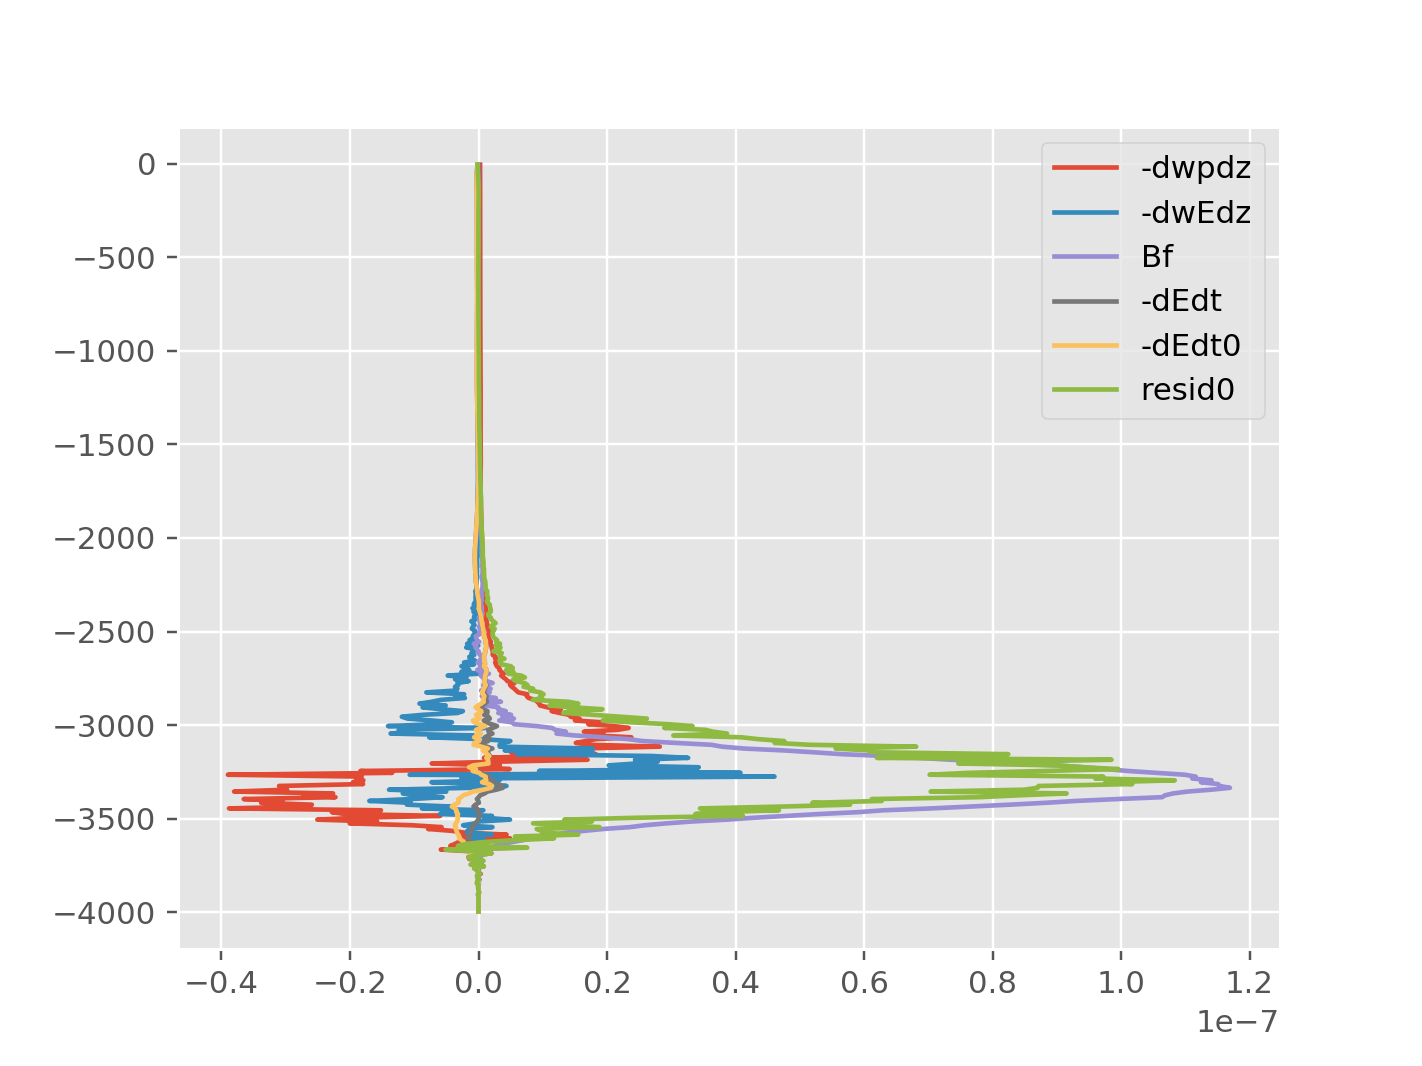

<xarray.DataArray ()>
dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=()>
38.7199718595


In [134]:
fig,ax = plt.subplots()
ax.plot(-energy[1]['dWPdz']/area,energy[1]['Z'],label='-dwpdz')
ax.plot(-np.convolve(energy[1]['dwEdz'], np.ones(1)/1., mode='same')/area,energy[1]['Z'],label='-dwEdz')
ax.plot(energy[1]['Bf']/area,energy[1]['Z'],label='Bf')

#ax.plot((energy[2]['KE']/area-energy[0]['KE']/area)/3600,energy[1]['Z'])
#ax.plot((energy[2]['PE']/area-energy[0]['PE']/area)/3600,energy[1]['Z'],label='PE')
#ax.plot((energy[2]['PE0']/area-energy[0]['PE0']/area)/3600,energy[1]['Z'],label='PE0')
dEdt = (energy[2]['KE']/area-energy[0]['KE']/area)/3600 + (energy[2]['PEw']/area-energy[0]['PEw']/area)/3600
dEdt0 = (energy[2]['KE']/area-energy[0]['KE']/area)/3600 + (energy[2]['PE']/area-energy[0]['PE']/area)/3600
#ax.plot((energy[2]['PEbad']/area-energy[0]['PEbad']/area)/3600,energy[1]['Z'])
ax.plot(-np.convolve(dEdt, np.ones(10)/10., mode='same'), energy[1]['Z'],label='-dEdt')
ax.plot(-np.convolve(dEdt0, np.ones(10)/10., mode='same'), energy[1]['Z'],label='-dEdt0')
#ax.plot(-dEdt0,energy[1]['Z'],label='-dEdt0')
resid = (-energy[1]['dWPdz']/area + energy[1]['Bf']/area -
        dEdt0 - energy[1]['dwEdz']/area)
resid0 = (-energy[1]['dWPdz']/area + energy[1]['Bf']/area -
        dEdt - 0*energy[1]['dwEdz']/area  )
    
#ax.plot(np.convolve(resid,np.ones(10)/10,mode='same'),energy[1]['Z'],label='resid')
ax.plot(np.convolve(resid0,np.ones(1)/1,mode='same'),energy[1]['Z'],label='resid0')
ax.legend()
print(np.sum(resid0*1e6*10.))
print(np.sum(energy[1]['Bf']/area*1e6*10.))

<IPython.core.display.Javascript object>


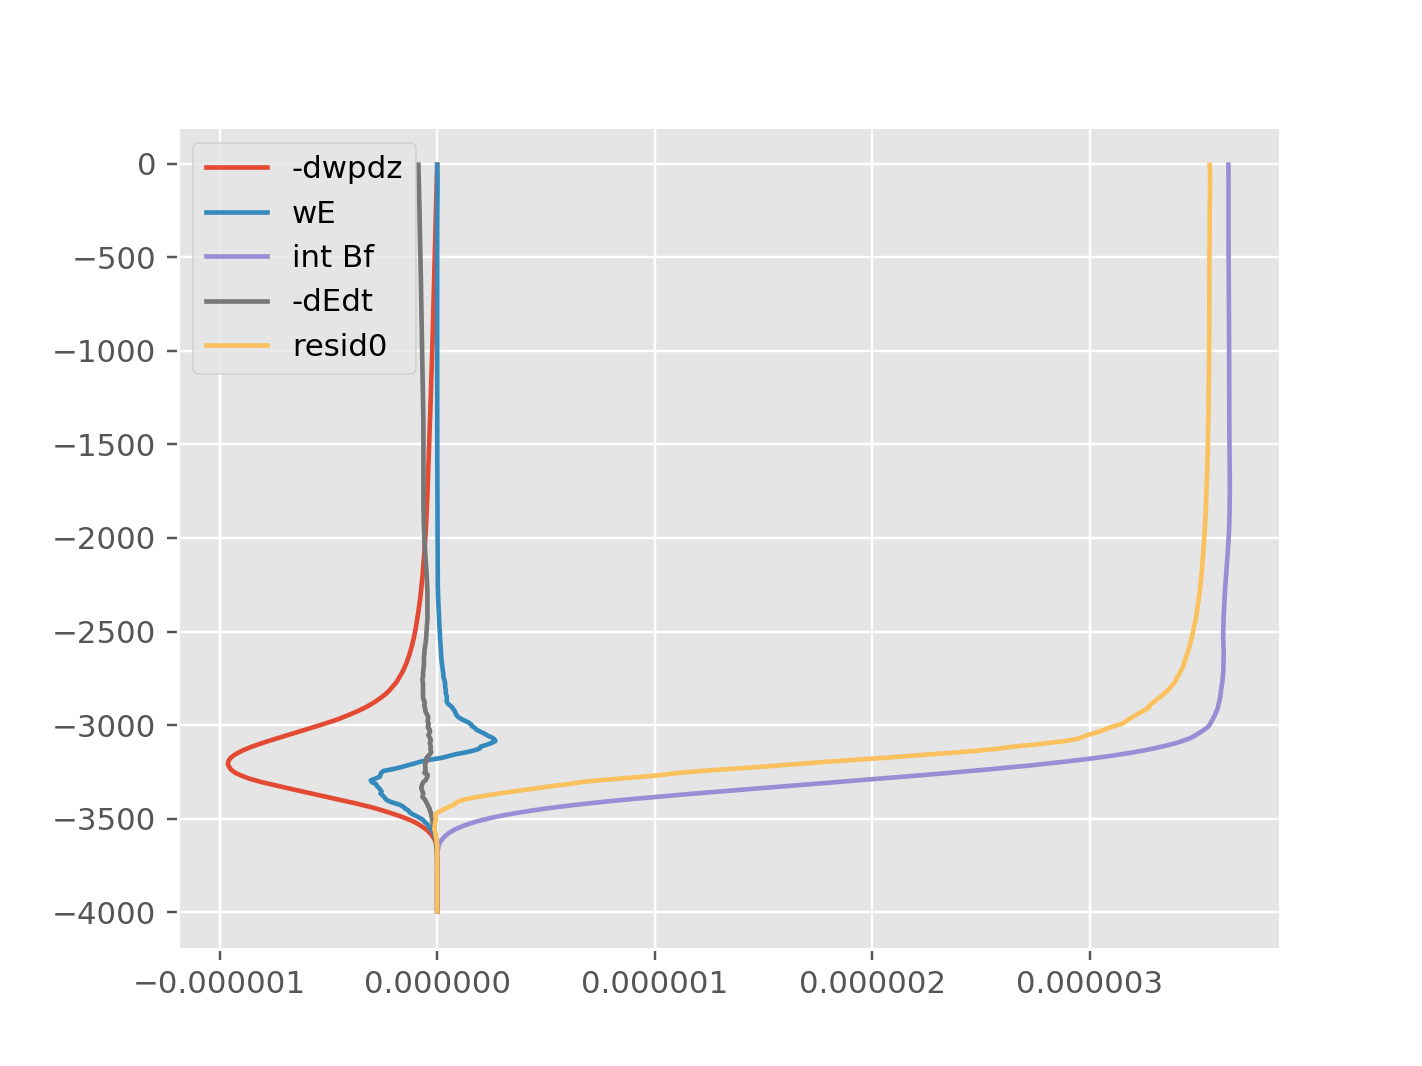

<xarray.DataArray ()>
dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=()>
36.3766997061
<xarray.DataArray ()>
array(0.8627969210745515)
<xarray.DataArray ()>
array(2.194456852743525)


In [186]:
fig,ax = plt.subplots()
ax.plot(-np.cumsum(energy[1]['dWPdz'].values[::-1])[::-1]/area,energy[1]['Z'],label='-dwpdz')
ax.plot(-np.cumsum(energy[1]['dwEdz'][::-1])[::-1]/area,energy[1]['Z'],label='wE')
ax.plot(np.cumsum(energy[1]['Bf'][::-1])[::-1]/area,energy[1]['Z'],label='int Bf')

#ax.plot((energy[2]['KE']/area-energy[0]['KE']/area)/3600,energy[1]['Z'])
#ax.plot((energy[2]['PE']/area-energy[0]['PE']/area)/3600,energy[1]['Z'],label='PE')
#ax.plot((energy[2]['PE0']/area-energy[0]['PE0']/area)/3600,energy[1]['Z'],label='PE0')
dEdt = (energy[2]['KE']/area-energy[0]['KE']/area)/3600 + (energy[2]['PEw']/area-energy[0]['PEw']/area)/3600
dEdt0 = (energy[2]['KE']/area-energy[0]['KE']/area)/3600 + (energy[2]['PE']/area-energy[0]['PE']/area)/3600
#ax.plot((energy[2]['PEbad']/area-energy[0]['PEbad']/area)/3600,energy[1]['Z'])
ax.plot(-np.cumsum(dEdt.values[::-1])[::-1],energy[1]['Z'],label='-dEdt')
#ax.plot(-dEdt0,energy[1]['Z'],label='-dEdt0')
resid = (-energy[1]['dWPdz']/area + energy[1]['Bf']/area -
        dEdt )
resid0 = (-energy[1]['dWPdz']/area + energy[1]['Bf']/area -
        dEdt - energy[1]['dwEdz']/area  )
    
#ax.plot(np.convolve(resid,np.ones(10)/10,mode='same'),energy[1]['Z'],label='resid')
ax.plot(np.cumsum(resid0.values[::-1])[::-1],energy[1]['Z'],label='resid0')
ax.legend()
print(np.sum(resid0*1e6*10.))
print(np.sum(energy[1]['Bf']/area*1e6*10.))
print(np.sum(dEdt*1e6*10.))
print(np.sum(dEdt0*1e6*10.))

<IPython.core.display.Javascript object>


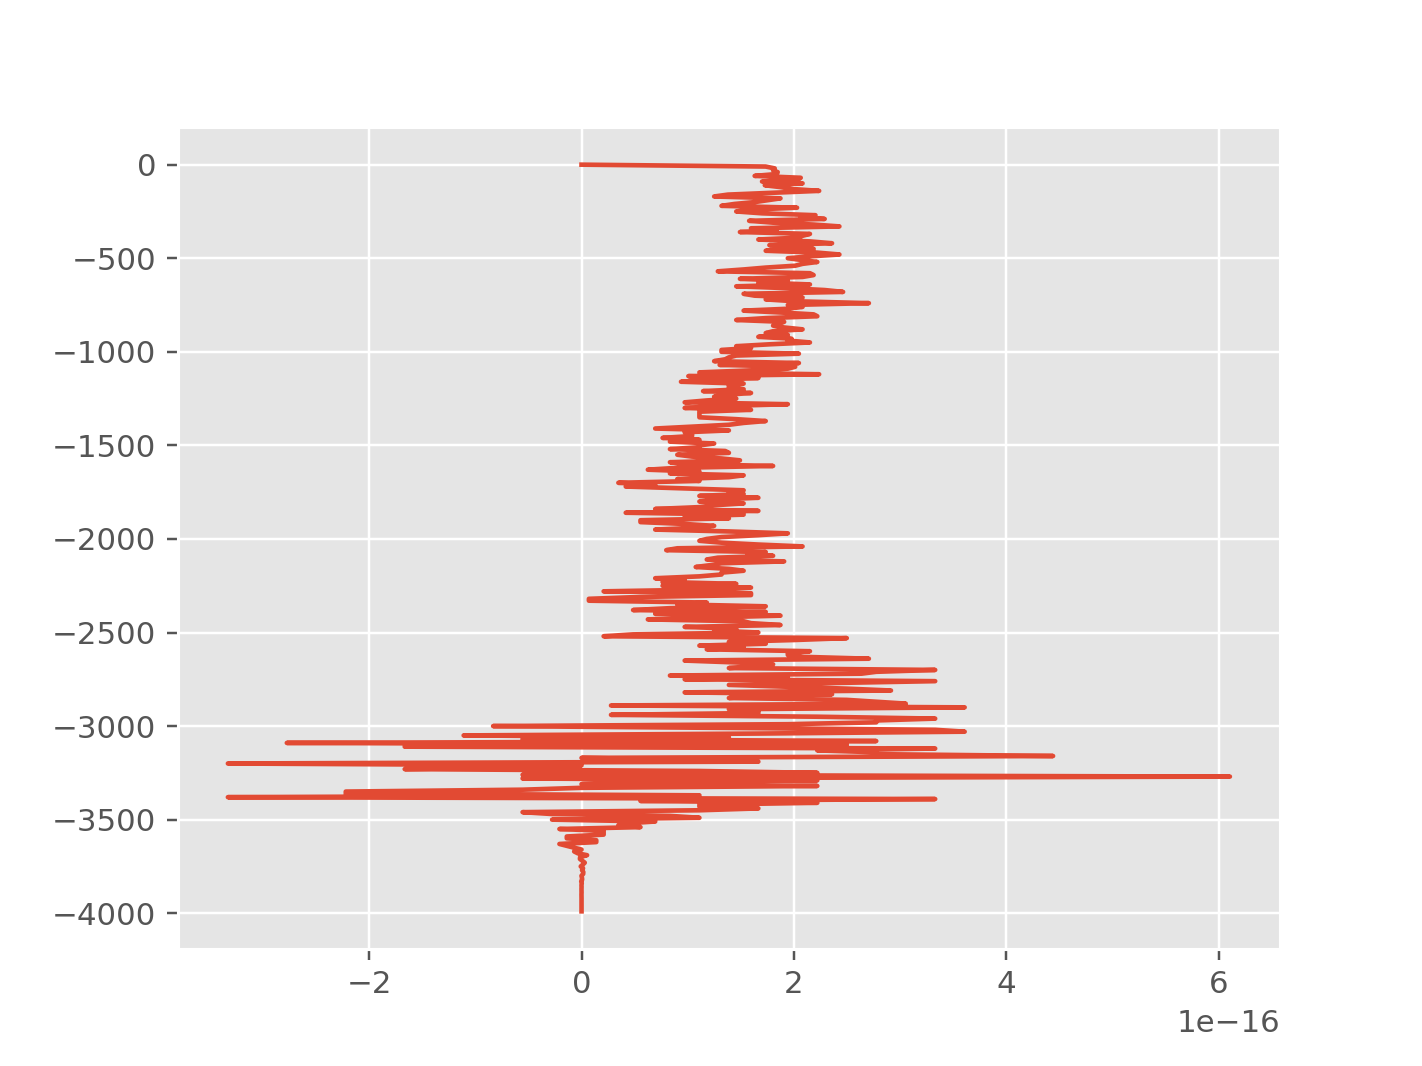

In [341]:
fig,ax = plt.subplots()
ax.plot(dss[0]['W'].sum(dim={'XC','YC'})[0],dss[0]['Zl'])

## Tseng Ferziger 2001

doi://10.1063/1.1358307

Get a cdf of temperature and match to cumulative area as a fnction of z.  That will give a z for each temperature in the CDF, and then remap onto zgrid.


In [173]:
t = dss[0]['T']
t = t.where(t>20.)
bins = np.linspace(t.min().values, t.max().values, 40000)
t = dss[0]['T'].data
# histogram the tempreatures...
N, bins = da.histogram(t, bins)
# get a curve of cumulative area as a function of temperature...
cumareasT = np.cumsum(N.compute())*np.mean(dss[0]['rA'].values)
Tbins = (bins[1:]+bins[:-1])/2.
# get a curve of cumulative area as a function of depth
cumareasZ = np.cumsum(energy[0]['areaZ'].values[::-1])
Z = dss[0]['Z'][::-1] + 5.
Z = Z[cumareasZ>1e-10]
cumareasZ = cumareasZ[cumareasZ>1e-10]
# get the depth of each temperature bin as a function of cumulative area.
zTbin = np.interp(cumareasT, cumareasZ,Z)
# now map back to grid z...  This is the minimum PE state 
# ok, this shouldn't be interpolated, it should be binned:
Tz = np.zeros(nz)
z = energy[0]['Z']
#for k in range(nz):
#    ind = np.where((zTbin > z[k] - 5.) & (zTbin <= z[k] + 5.))
#    Tz[k] = np.mean(Tbins[ind])
Tz = np.interp(energy[0]['Z'], zTbin, Tbins)

/Users/jklymak/anaconda3/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


In [169]:
fig,ax = plt.subplots(1,2)

#binmid = bins[:-1]
ax[0].plot(Tbins, cumareasT)
ax[1].plot(,np.cumsum(energy[0]['areaZ'].values[::-1]))


SyntaxError: invalid syntax (<ipython-input-169-b99536303b47>, line 5)

<IPython.core.display.Javascript object>


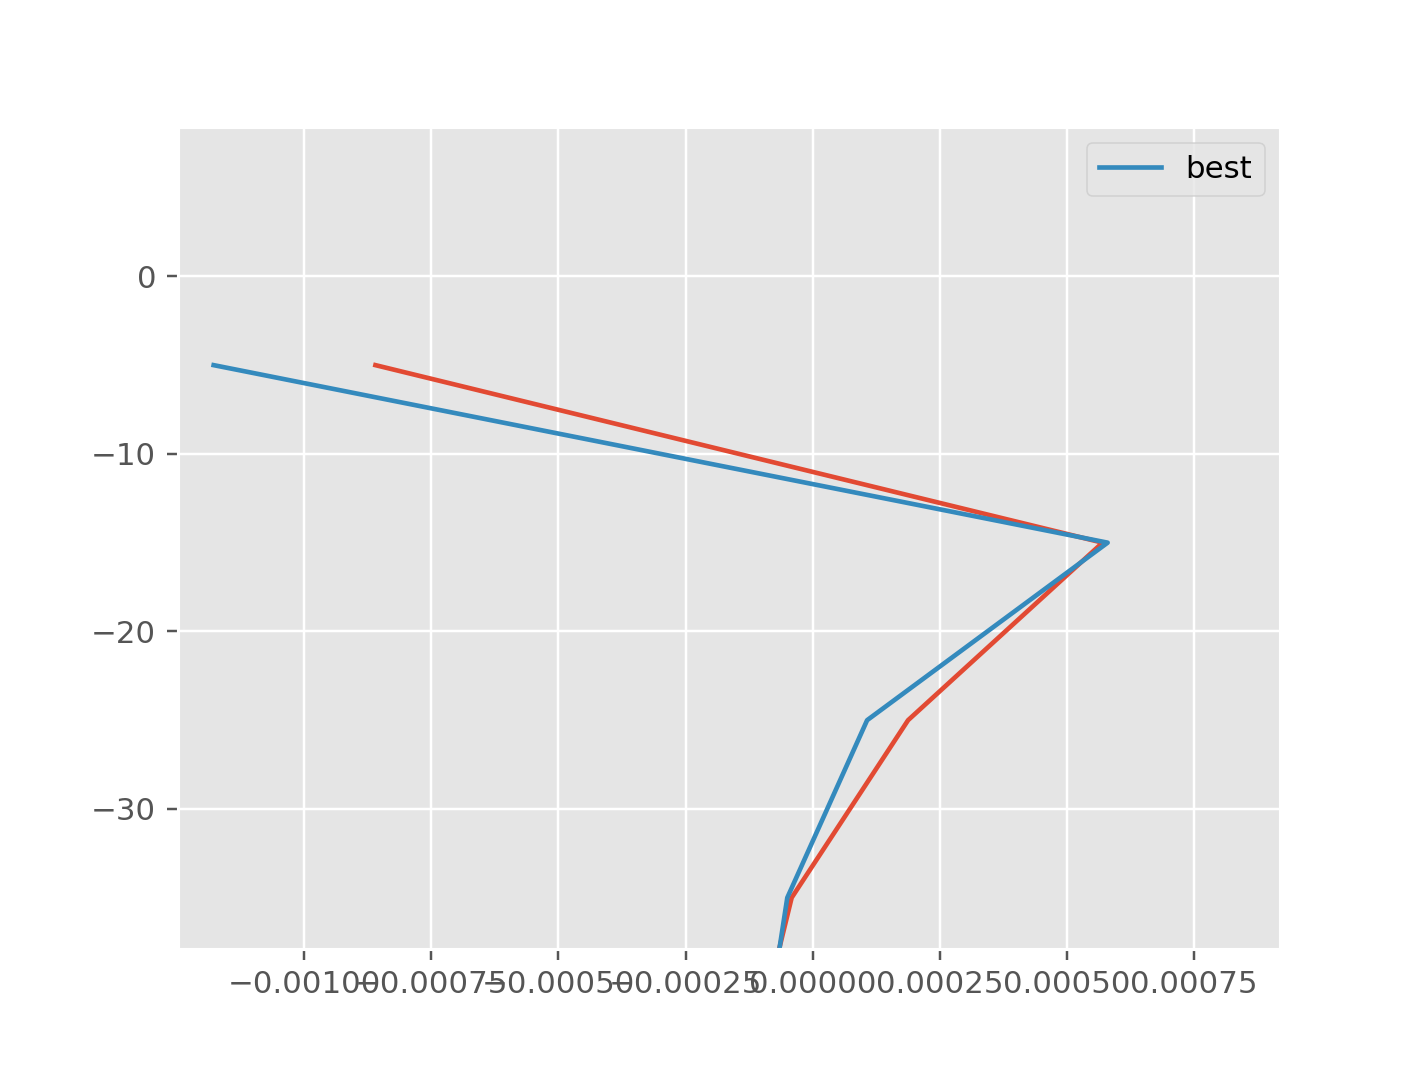

In [174]:
# so for each value in binmid, get a z

fig,ax = plt.subplots()
#ax.plot(Tbins, zTbin)
# ax.plot(binmid, zbin,'x')
ax.plot(energy[0]['Tz']-T0, energy[0]['Z'])

ax.plot(Tz-T0, energy[0]['Z'], label='best')
#ax.plot(Tzz-T0, energy[0]['Z'])
ax.legend()

So this is quite a bit different from the profile from just taking the mean.  It also doesn't *seem* too expensive since `dask.Array` has a `histogram` function (yay!)  So, does it change the energy?  


# see if wE changes much with time.

In [297]:
N0=1e-3
g=9.8
alpha = 2e-4
dz=10.
T0 = 28-np.cumsum(N0**2/g/alpha*dz*np.ones(400))
U0 = 0.1
iters = range(36000,36181,15)
dss = list(np.zeros(len(iters)))
v0 = np.zeros(len(iters))
u0 = np.zeros(len(iters))

for i in range(len(iters)):
    n=i
    nm='%s/ds%010d.nc'%(pre,iters[i])
    print(nm)
    dss[i] = xr.open_dataset(nm, chunks={'Z':30,'Zl':30})
    ny = dss[i].sizes['YC']
    nx = dss[i].sizes['XC']
    
    dss[i]['T0']=(('Z'),T0)
    
    if submean:
        v0[i] = (dss[i]['V'].isel(Z=slice(50,200)).mean()).values
        u0[i] = (dss[i]['U'].isel(Z=slice(50,200)).mean()).values-U0
    else:
        v0[i]=0.
        u0[i]=0.
    #    indx = np.where(np.abs(dss[n]['X']-np.mean(dss[n]['X']))<34e3)[0]
    
    #    indx = np.where(np.abs(dss[n]['X']-np.mean(dss[n]['X']))<34e3)[0]
    dss[n]['V']=dss[n]['V']-v0[i]
    dss[n]['U']=dss[n]['U']-u0[i]
ds = dss[6]

CW3dfull01U10/ds0000036000.nc
CW3dfull01U10/ds0000036015.nc
CW3dfull01U10/ds0000036030.nc
CW3dfull01U10/ds0000036045.nc
CW3dfull01U10/ds0000036060.nc
CW3dfull01U10/ds0000036075.nc
CW3dfull01U10/ds0000036090.nc
CW3dfull01U10/ds0000036105.nc
CW3dfull01U10/ds0000036120.nc
CW3dfull01U10/ds0000036135.nc
CW3dfull01U10/ds0000036150.nc
CW3dfull01U10/ds0000036165.nc
CW3dfull01U10/ds0000036180.nc


In [310]:
# get d/dz wE:
wE = np.zeros((400,len(dss)))
for n in range(len(dss)):
    smoothU = False
    if smoothU:
        u = (dss[n]['U']+dss[n]['U'].roll(XG=1).data+dss[n]['U'].roll(Z=1).data +
            dss[n]['U'].roll(Z=1,XG=1).data)/4. # +dss[n]['U'].roll(XG=-1).data + dss[n]['U'].roll(Z=-1).data)/4. 
    else:
        u = dss[n]['U']
    xx = (0.5*(u**2 * dss[n]['rA'].data * dss[n]['hFacC'].data * 
               dss[n]['W'].data)).sum(dim=('XG','YC')).compute()
    uu = xx.copy()
    #xx += (0.5*0.5*(dss[n]['U'].roll(XG=1)**2 ) *
    #       dss[n]['rA'].data * dss[n]['W'].data).sum(dim=('XG','YC')).compute()
    #v = 0.2*(dss[n]['V']+dss[n]['V'].roll(YG=1)+dss[n]['V'].roll(YG=-1)+dss[n]['V'].roll(XC=1)++dss[n]['V'].roll(XC=-1))
    if smoothU:
        v = (dss[n]['V']+dss[n]['V'].roll(YG=1).data +
             dss[n]['V'].roll(Z=1).data + dss[n]['V'].roll(Z=1).roll(YG=1).data )/4. # +dss[n]['V'].roll(YG=-1).data + dss[n]['V'].roll(Z=-1).data )/4. #+dss[n]['V'].roll(XC=1)++dss[n]['V'].roll(XC=-1))
    else:
        v = dss[n]['V']
    xx = xx + (0.5*(v**2 ) * dss[n]['hFacC'].data *
           dss[n]['rA'].data * dss[n]['W'].data).sum(dim=('XC','YG')).compute()
    vv = xx.copy() - uu.copy()


    xx = xx + (0.5*(dss[n]['W']**3 ) * dss[n]['hFacC'].data *
           dss[n]['rA'].data).sum(dim=('XC','YC')).data


    #xx = xx*2.
    #xx += (0.5*0.5*(dss[n]['V'].roll(YG=1)**2 ) *
    #       dss[n]['rA'].data* dss[n]['W'].data).sum(dim=('XC','YG')).compute()
    T = dss[n]['T'].values[0]
    nz,ny,nx = np.shape(T)
    for k in range(nz):
        T[k][T[k]==0]=(energy[1]['Tznew'].values)[k]
    dss[n]['Tf'] = dss[n]['T']*0. + T   


    if 0:
        t = (dss[n]['Tf'] + dss[n]['Tf'].roll(YC=1).data + dss[n]['Tf'].roll(YC=-1).data 
              + dss[n]['Tf'].roll(XC=1).data + dss[n]['Tf'].roll(YC=-1).data)/5.
    else:
        t = dss[n]['T']
    xx += (((g * 2e-4 * (t - energy[1]['Tznew']) * dss[n]['hFacC'])**2 / 2. / N00[np.newaxis,:,np.newaxis,np.newaxis]) * 
              dss[n]['rA']* dss[n]['W'].data).sum(dim=('XC','YC')).compute()
    #xx += ((g*2e-4*(dss[n]['T']-dss[n]['Tz']))*dss[n]['hFacC']*dss[n]['rA']*(dss[n]['Z']) * dss[n]['W'].data).sum(dim=('XC','YC')).compute()

    wE[:,n] = xx


# xx is KE on Z, but W is on Z1

<IPython.core.display.Javascript object>


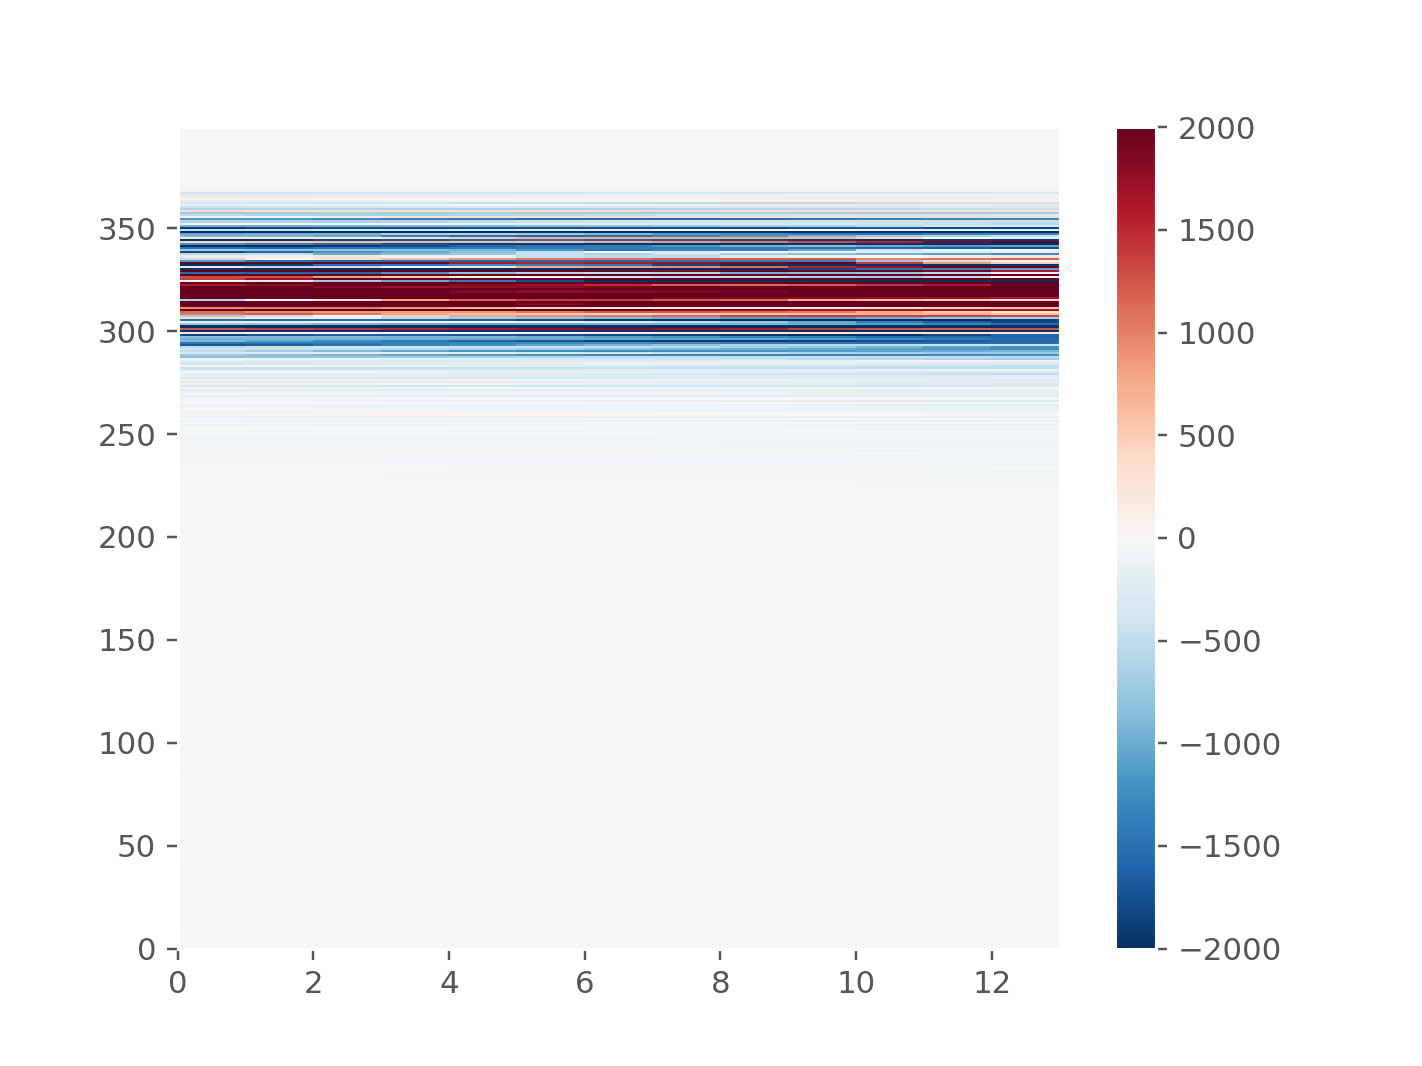

<IPython.core.display.Javascript object>


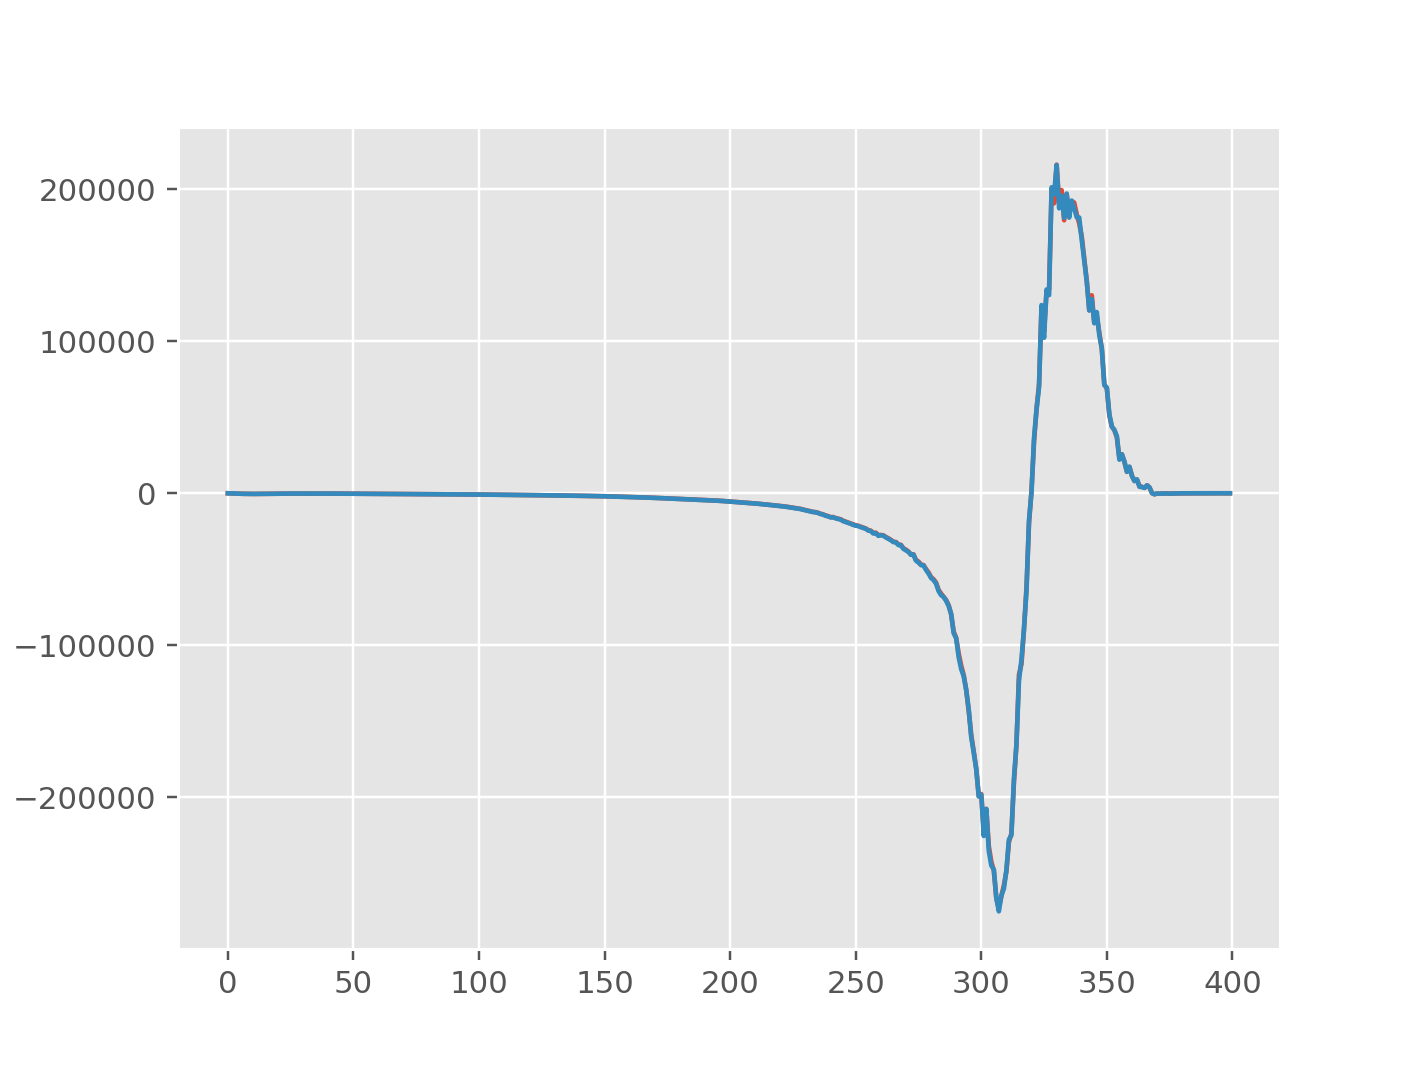

In [311]:
fig,ax = plt.subplots()
pcm = ax.pcolormesh(np.diff(wE,axis=0)/10., cmap='RdBu_r', vmin=-2000, vmax=2000)
fig.colorbar(pcm, ax=ax)

fig,ax = plt.subplots()
ax.plot(wE.mean(axis=1))
ax.plot(wE[:,6])